(cfa_sem_notebook)=
# Confirmatory Factor Analysis and Structural Equation Models

:::{post} September, 2024
:tags: cfa, sem, regression, 
:category: intermediate, reference
:author: Nathaniel Forde
:::

This is some introductory text. 

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import seaborn as sns

In [2]:
%config InlineBackend.figure_format = 'retina'  # high resolution figures
az.style.use("arviz-darkgrid")
rng = np.random.default_rng(42)

### Latent Constructs and Measurement

In [3]:
df = pd.read_csv("../data/sem_data.csv")
df.head()

ID region  gender  age  se_acad_p1  se_acad_p2  se_acad_p3  se_social_p1  \
0   1   west  female   13    4.857143    5.571429    4.500000          5.80   
1   2   west    male   14    4.571429    4.285714    4.666667          5.00   
2  10   west  female   14    4.142857    6.142857    5.333333          5.20   
3  11   west  female   14    5.000000    5.428571    4.833333          6.40   
4  12   west  female   14    5.166667    5.600000    4.800000          5.25   

   se_social_p2  se_social_p3  sup_friends_p1  sup_friends_p2  sup_friends_p3  \
0      5.500000          5.40             6.5             6.5             7.0   
1      5.500000          4.80             4.5             4.5             5.5   
2      4.666667          6.00             4.0             4.5             3.5   
3      5.833333          6.40             7.0             7.0             7.0   
4      5.400000          5.25             7.0             7.0             7.0   

   sup_parents_p1  sup_parents_p2  sup_parents_p3     ls_p1  ls_p2  ls_p3  
0             7.0             7.0             6.0  5.333333   6.75   5.50  
1             5.0             6.0             4.5  4.333333   5.00   4.50  
2             7.0             7.0             6.5  6.333333   5.50   4.00  
3             7.0             7.0             7.0  4.333333   6.50   6.25  
4             6.5             6.5             7.0  5.666667   6.00   5.75

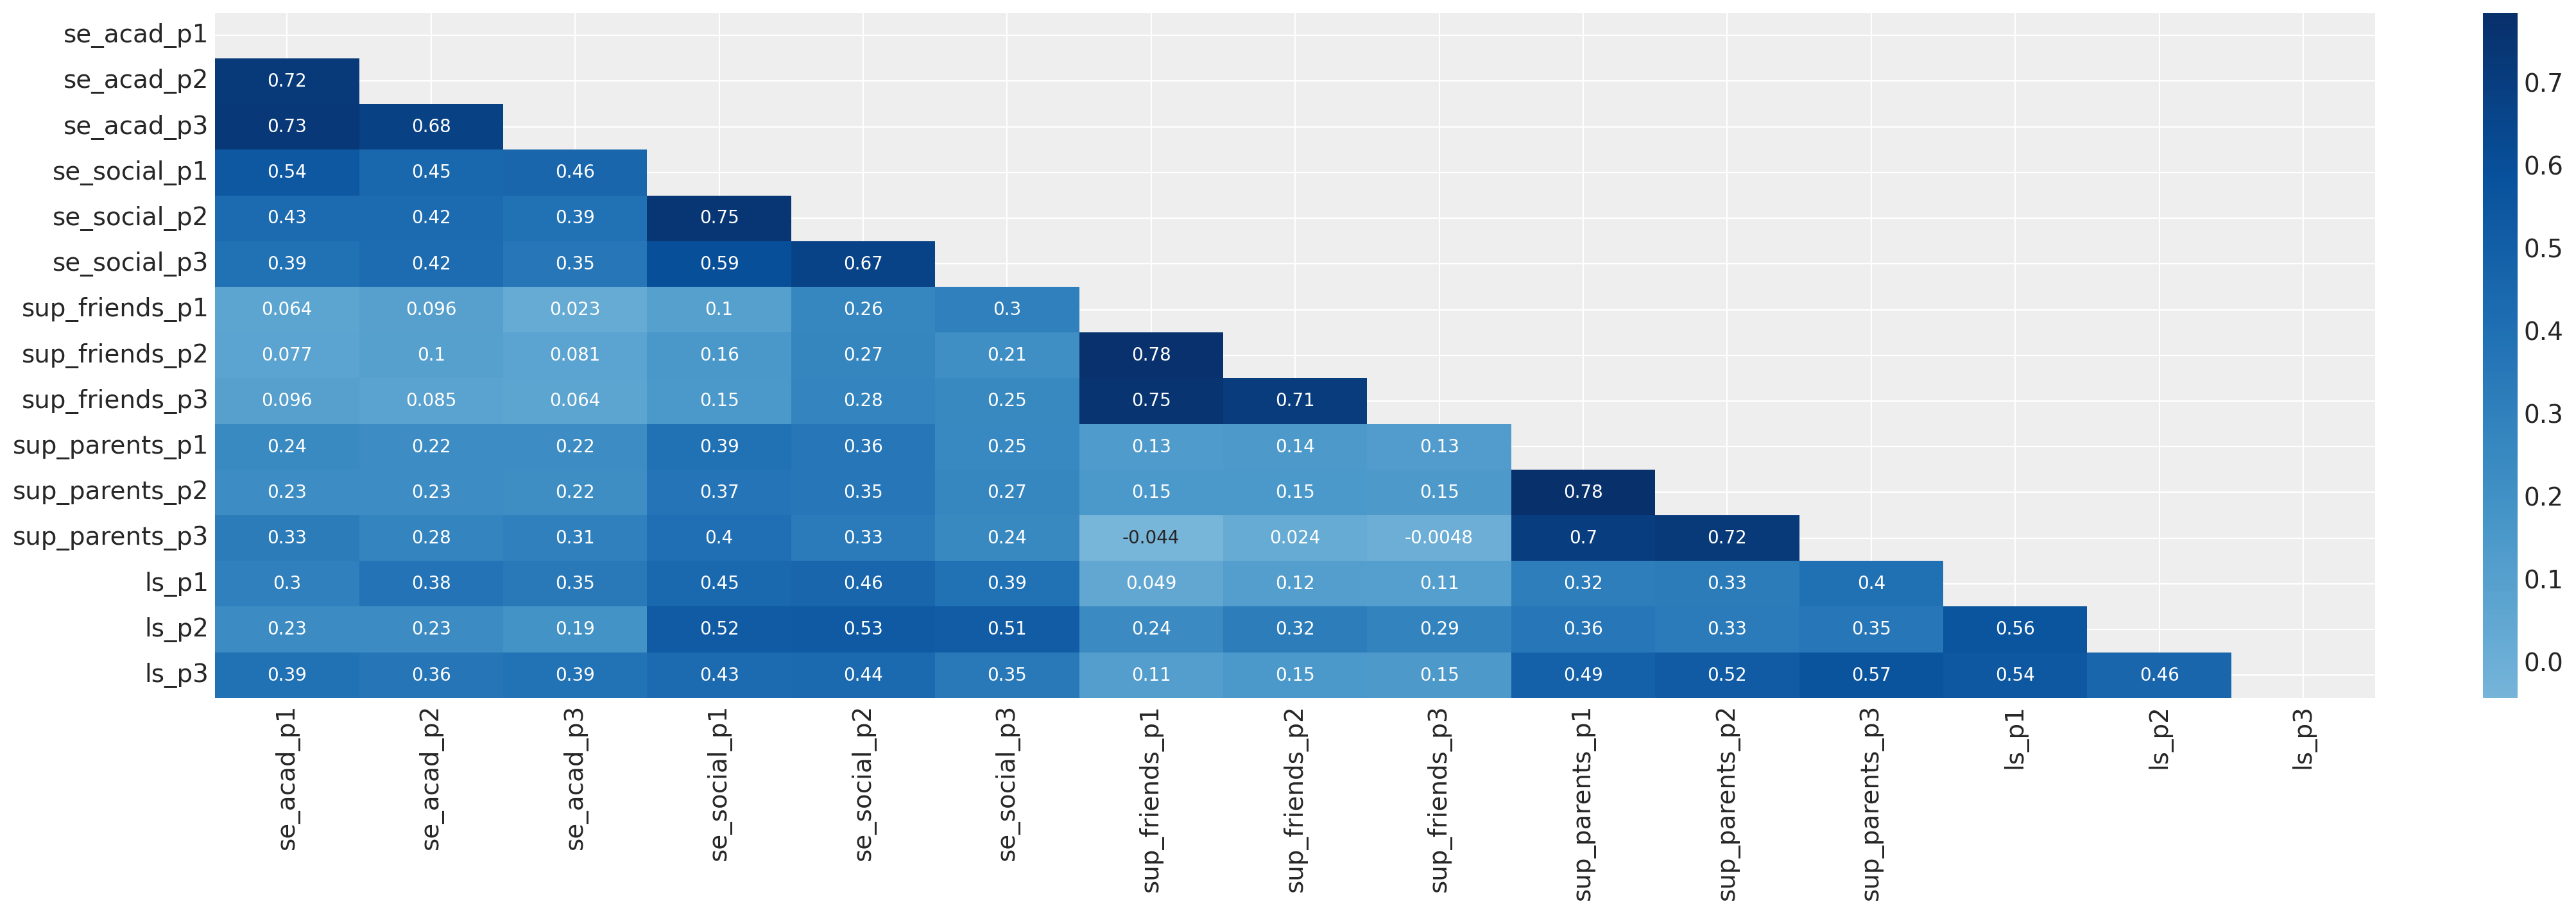

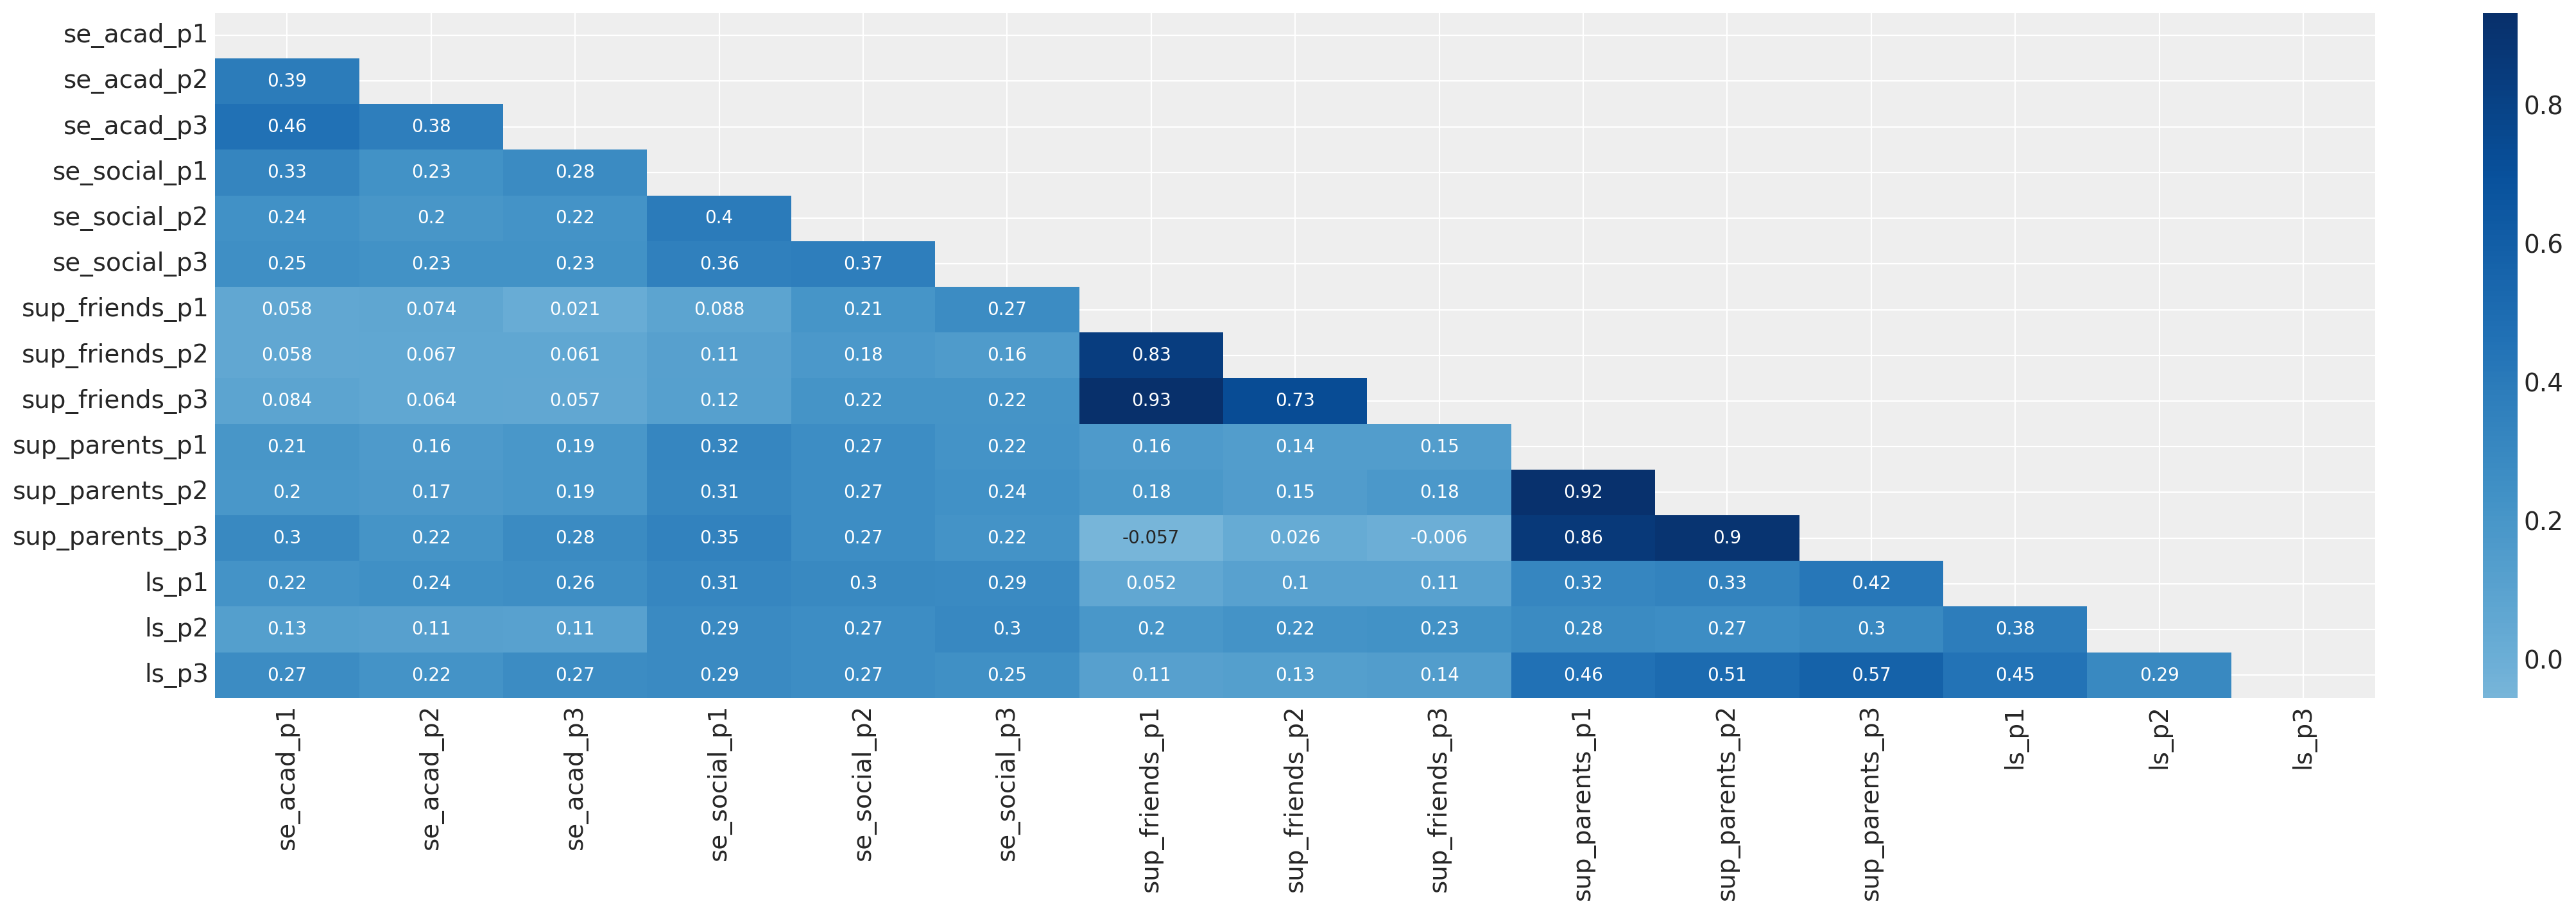

In [4]:
fig, ax = plt.subplots(figsize=(20, 7))
drivers = [c for c in df.columns if not c in ["region", "gender", "age", "ID"]]
corr_df = df[drivers].corr()
mask = np.triu(np.ones_like(corr_df, dtype=bool))
sns.heatmap(corr_df, annot=True, cmap="Blues", ax=ax, center=0, mask=mask)
fig, ax = plt.subplots(figsize=(20, 7))
sns.heatmap(df[drivers].cov(), annot=True, cmap="Blues", ax=ax, center=0, mask=mask);

## Measurement Models

Compiling...
Compilation time = 0:00:02.201924
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:00:04.962723
Transforming variables...
Transformation time = 0:00:00.403047
Computing Log Likelihood...
Log Likelihood time = 0:00:00.264681
Sampling: [likelihood]


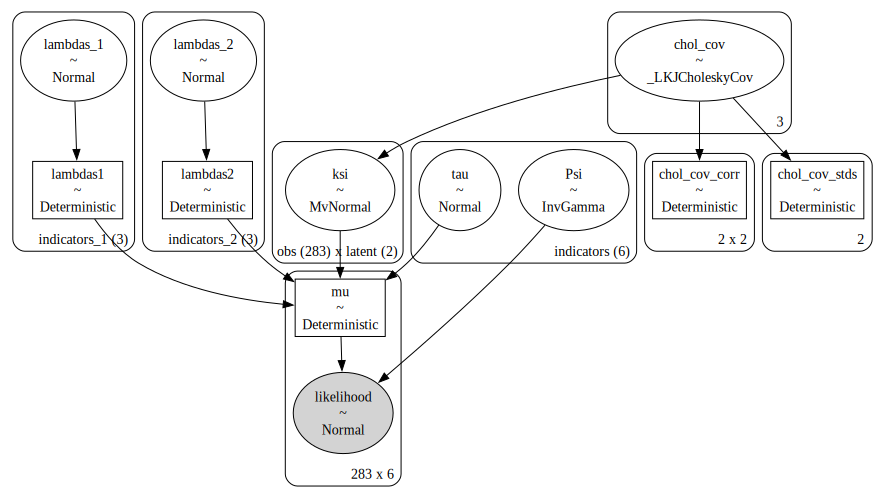

In [5]:
coords = {
    "obs": list(range(len(df))),
    "indicators": ["se_social_p1", "se_social_p2", "se_social_p3", "ls_p1", "ls_p2", "ls_p3"],
    "indicators_1": ["se_social_p1", "se_social_p2", "se_social_p3"],
    "indicators_2": ["ls_p1", "ls_p2", "ls_p3"],
    "latent": ["SE_SOC", "LS"],
}


obs_idx = list(range(len(df)))
with pm.Model(coords=coords) as model:

    Psi = pm.InverseGamma("Psi", 5, 10, dims="indicators")
    lambdas_ = pm.Normal("lambdas_1", 1, 10, dims=("indicators_1"))
    # Force a fixed scale on the factor loadings for factor 1
    lambdas_1 = pm.Deterministic(
        "lambdas1", pt.set_subtensor(lambdas_[0], 1), dims=("indicators_1")
    )
    lambdas_ = pm.Normal("lambdas_2", 1, 10, dims=("indicators_2"))
    # Force a fixed scale on the factor loadings for factor 2
    lambdas_2 = pm.Deterministic(
        "lambdas2", pt.set_subtensor(lambdas_[0], 1), dims=("indicators_2")
    )
    tau = pm.Normal("tau", 3, 10, dims="indicators")
    # Specify covariance structure between latent factors
    kappa = 0
    sd_dist = pm.Exponential.dist(1.0, shape=2)
    chol, _, _ = pm.LKJCholeskyCov("chol_cov", n=2, eta=2, sd_dist=sd_dist, compute_corr=True)
    ksi = pm.MvNormal("ksi", kappa, chol=chol, dims=("obs", "latent"))

    # Construct Observation matrix
    m1 = tau[0] + ksi[obs_idx, 0] * lambdas_1[0]
    m2 = tau[1] + ksi[obs_idx, 0] * lambdas_1[1]
    m3 = tau[2] + ksi[obs_idx, 0] * lambdas_1[2]
    m4 = tau[3] + ksi[obs_idx, 1] * lambdas_2[0]
    m5 = tau[4] + ksi[obs_idx, 1] * lambdas_2[1]
    m6 = tau[5] + ksi[obs_idx, 1] * lambdas_2[2]

    mu = pm.Deterministic("mu", pm.math.stack([m1, m2, m3, m4, m5, m6]).T)
    _ = pm.Normal(
        "likelihood",
        mu,
        Psi,
        observed=df[
            ["se_social_p1", "se_social_p2", "se_social_p3", "ls_p1", "ls_p2", "ls_p3"]
        ].values,
    )

    idata = pm.sample(
        nuts_sampler="numpyro", target_accept=0.95, idata_kwargs={"log_likelihood": True}
    )
    idata.extend(pm.sample_posterior_predictive(idata))

pm.model_to_graphviz(model)

In [6]:
az.summary(idata, var_names=["lambdas1", "lambdas2"])

/Users/nathanielforde/mambaforge/envs/pymc_causal/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/nathanielforde/mambaforge/envs/pymc_causal/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
lambdas1[se_social_p1]  1.000  0.000   1.000    1.000      0.000    0.000   
lambdas1[se_social_p2]  0.976  0.063   0.864    1.099      0.002    0.001   
lambdas1[se_social_p3]  0.944  0.076   0.801    1.085      0.002    0.001   
lambdas2[ls_p1]         1.000  0.000   1.000    1.000      0.000    0.000   
lambdas2[ls_p2]         0.811  0.080   0.658    0.949      0.003    0.002   
lambdas2[ls_p3]         0.859  0.090   0.702    1.036      0.003    0.002   

                        ess_bulk  ess_tail  r_hat  
lambdas1[se_social_p1]    4000.0    4000.0    NaN  
lambdas1[se_social_p2]     895.0    1515.0    1.0  
lambdas1[se_social_p3]    1364.0    1998.0    1.0  
lambdas2[ls_p1]           4000.0    4000.0    NaN  
lambdas2[ls_p2]            607.0    1075.0    1.0  
lambdas2[ls_p3]            931.0    1658.0    1.0

In [7]:
idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

/Users/nathanielforde/mambaforge/envs/pymc_causal/lib/python3.11/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Users/nathanielforde/mambaforge/envs/pymc_causal/lib/python3.11/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


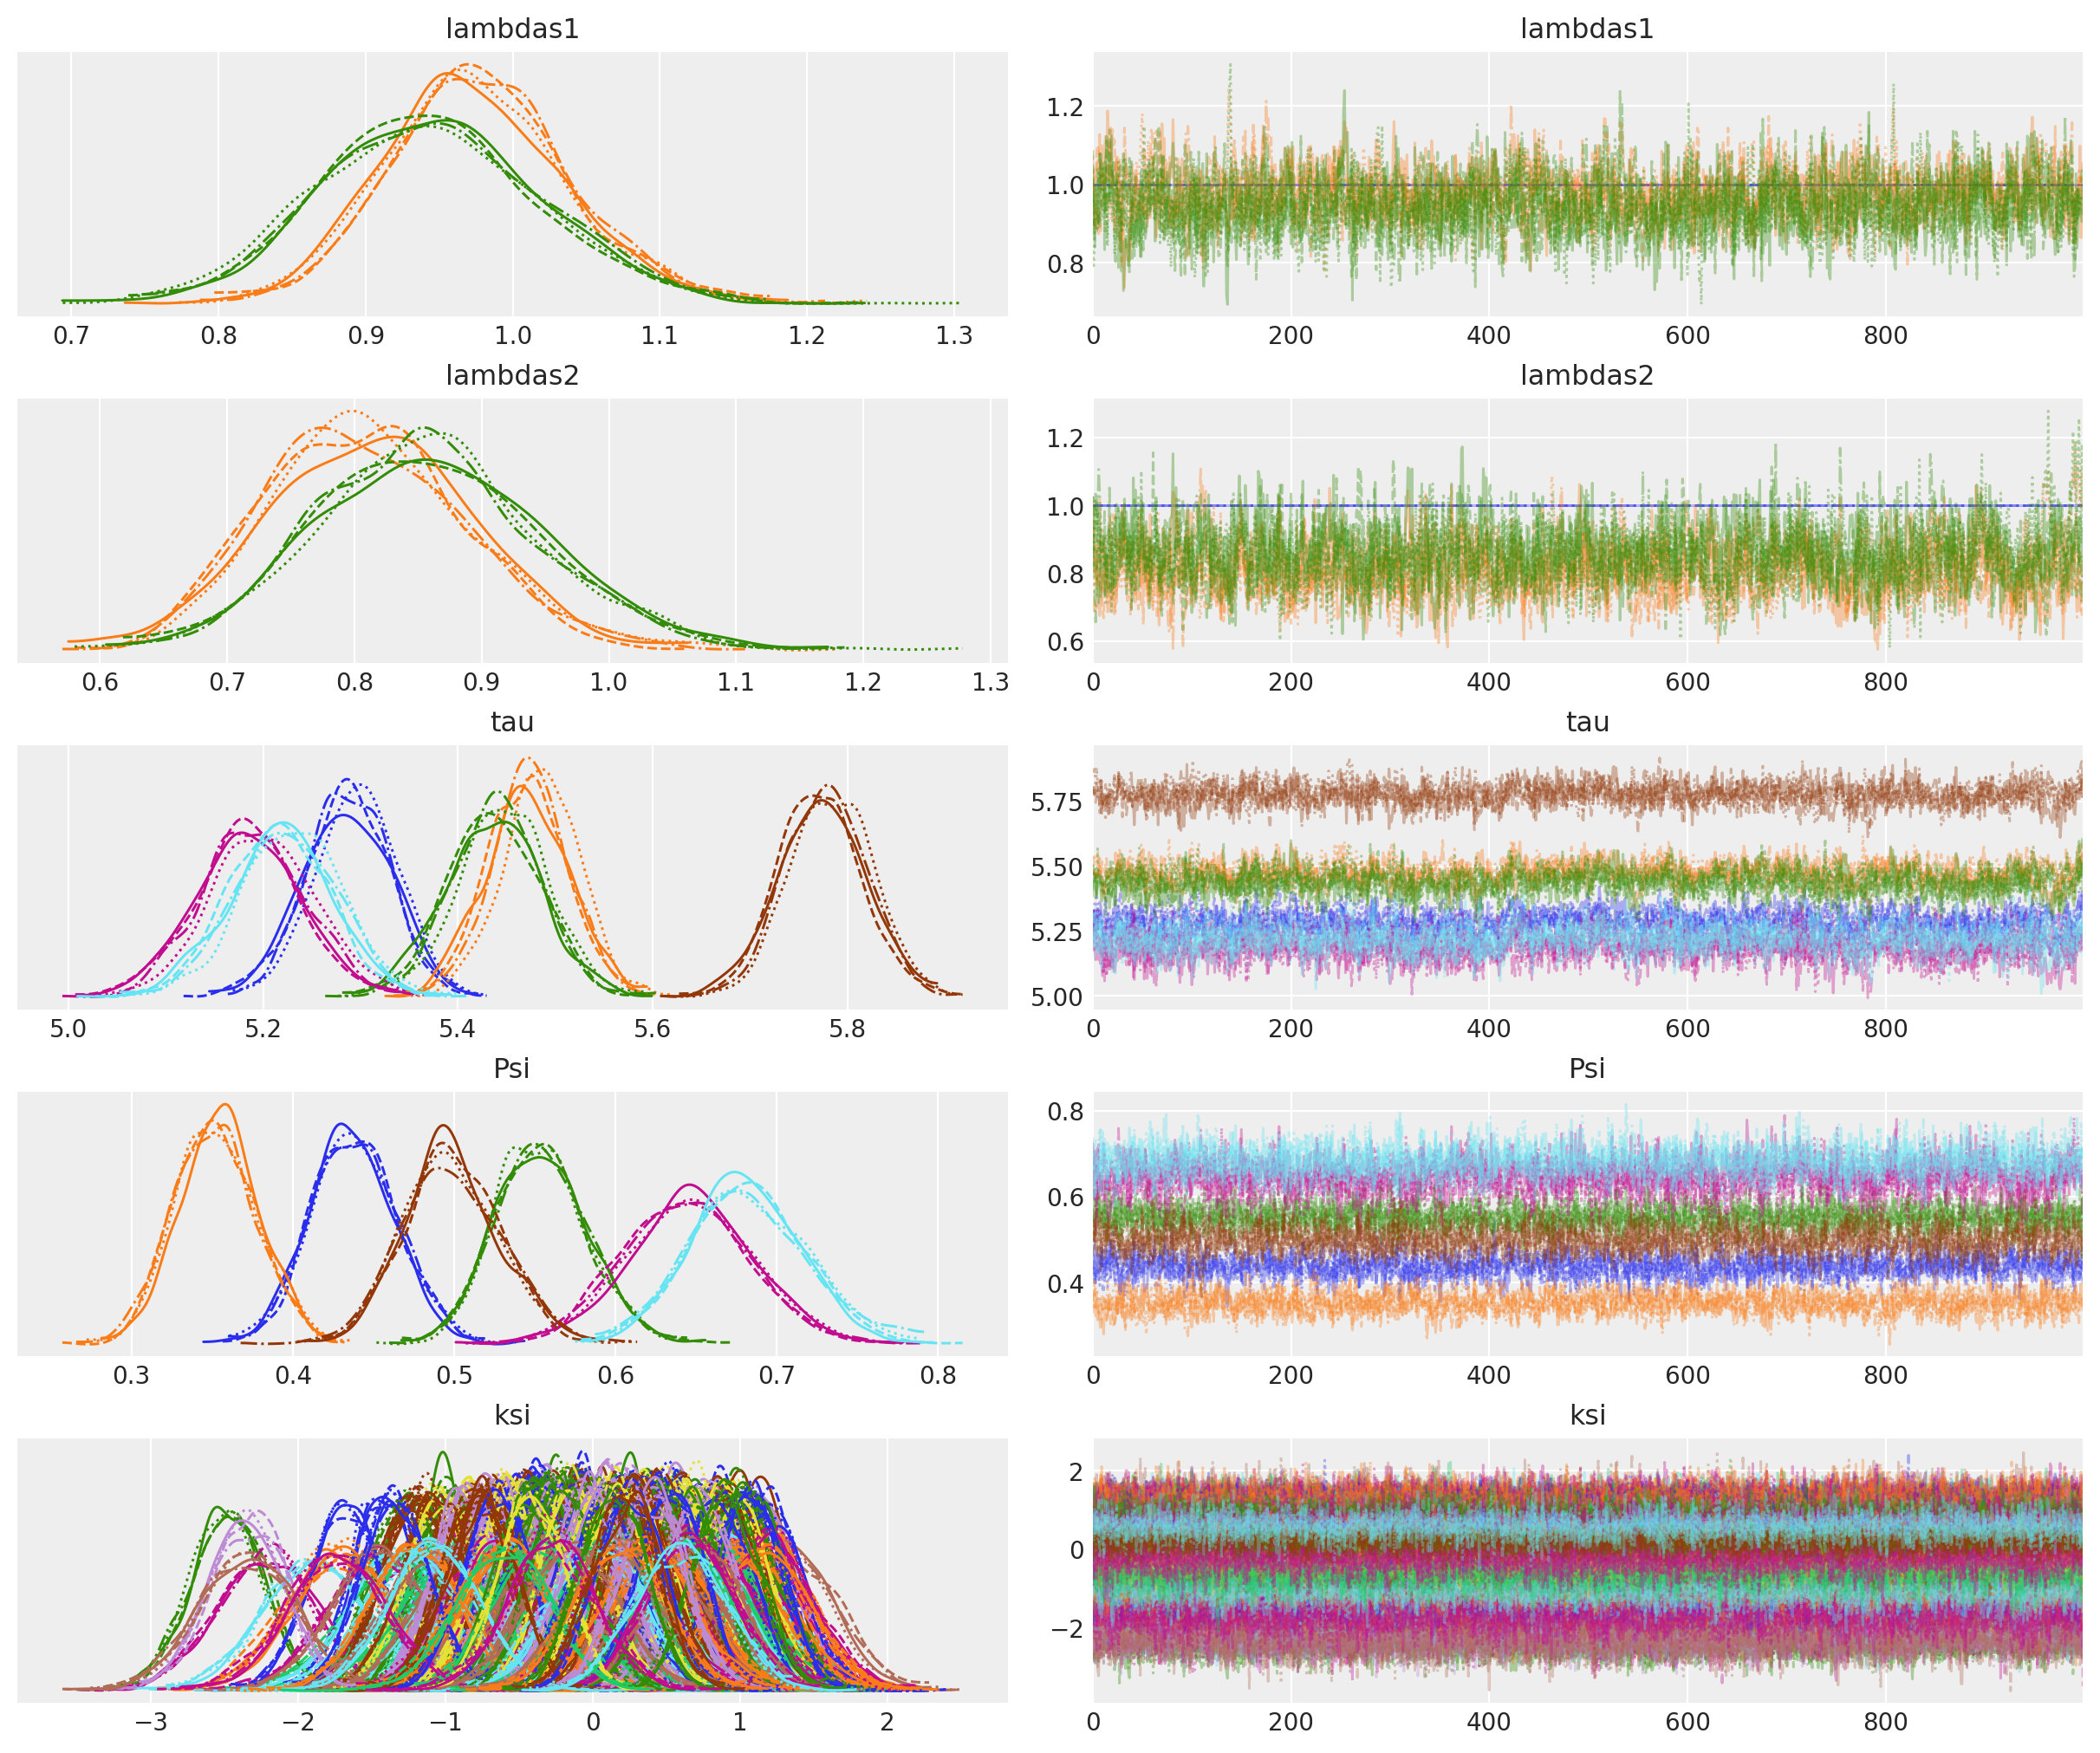

In [8]:
az.plot_trace(idata, var_names=["lambdas1", "lambdas2", "tau", "Psi", "ksi"]);

### Sampling the Latent Constructs

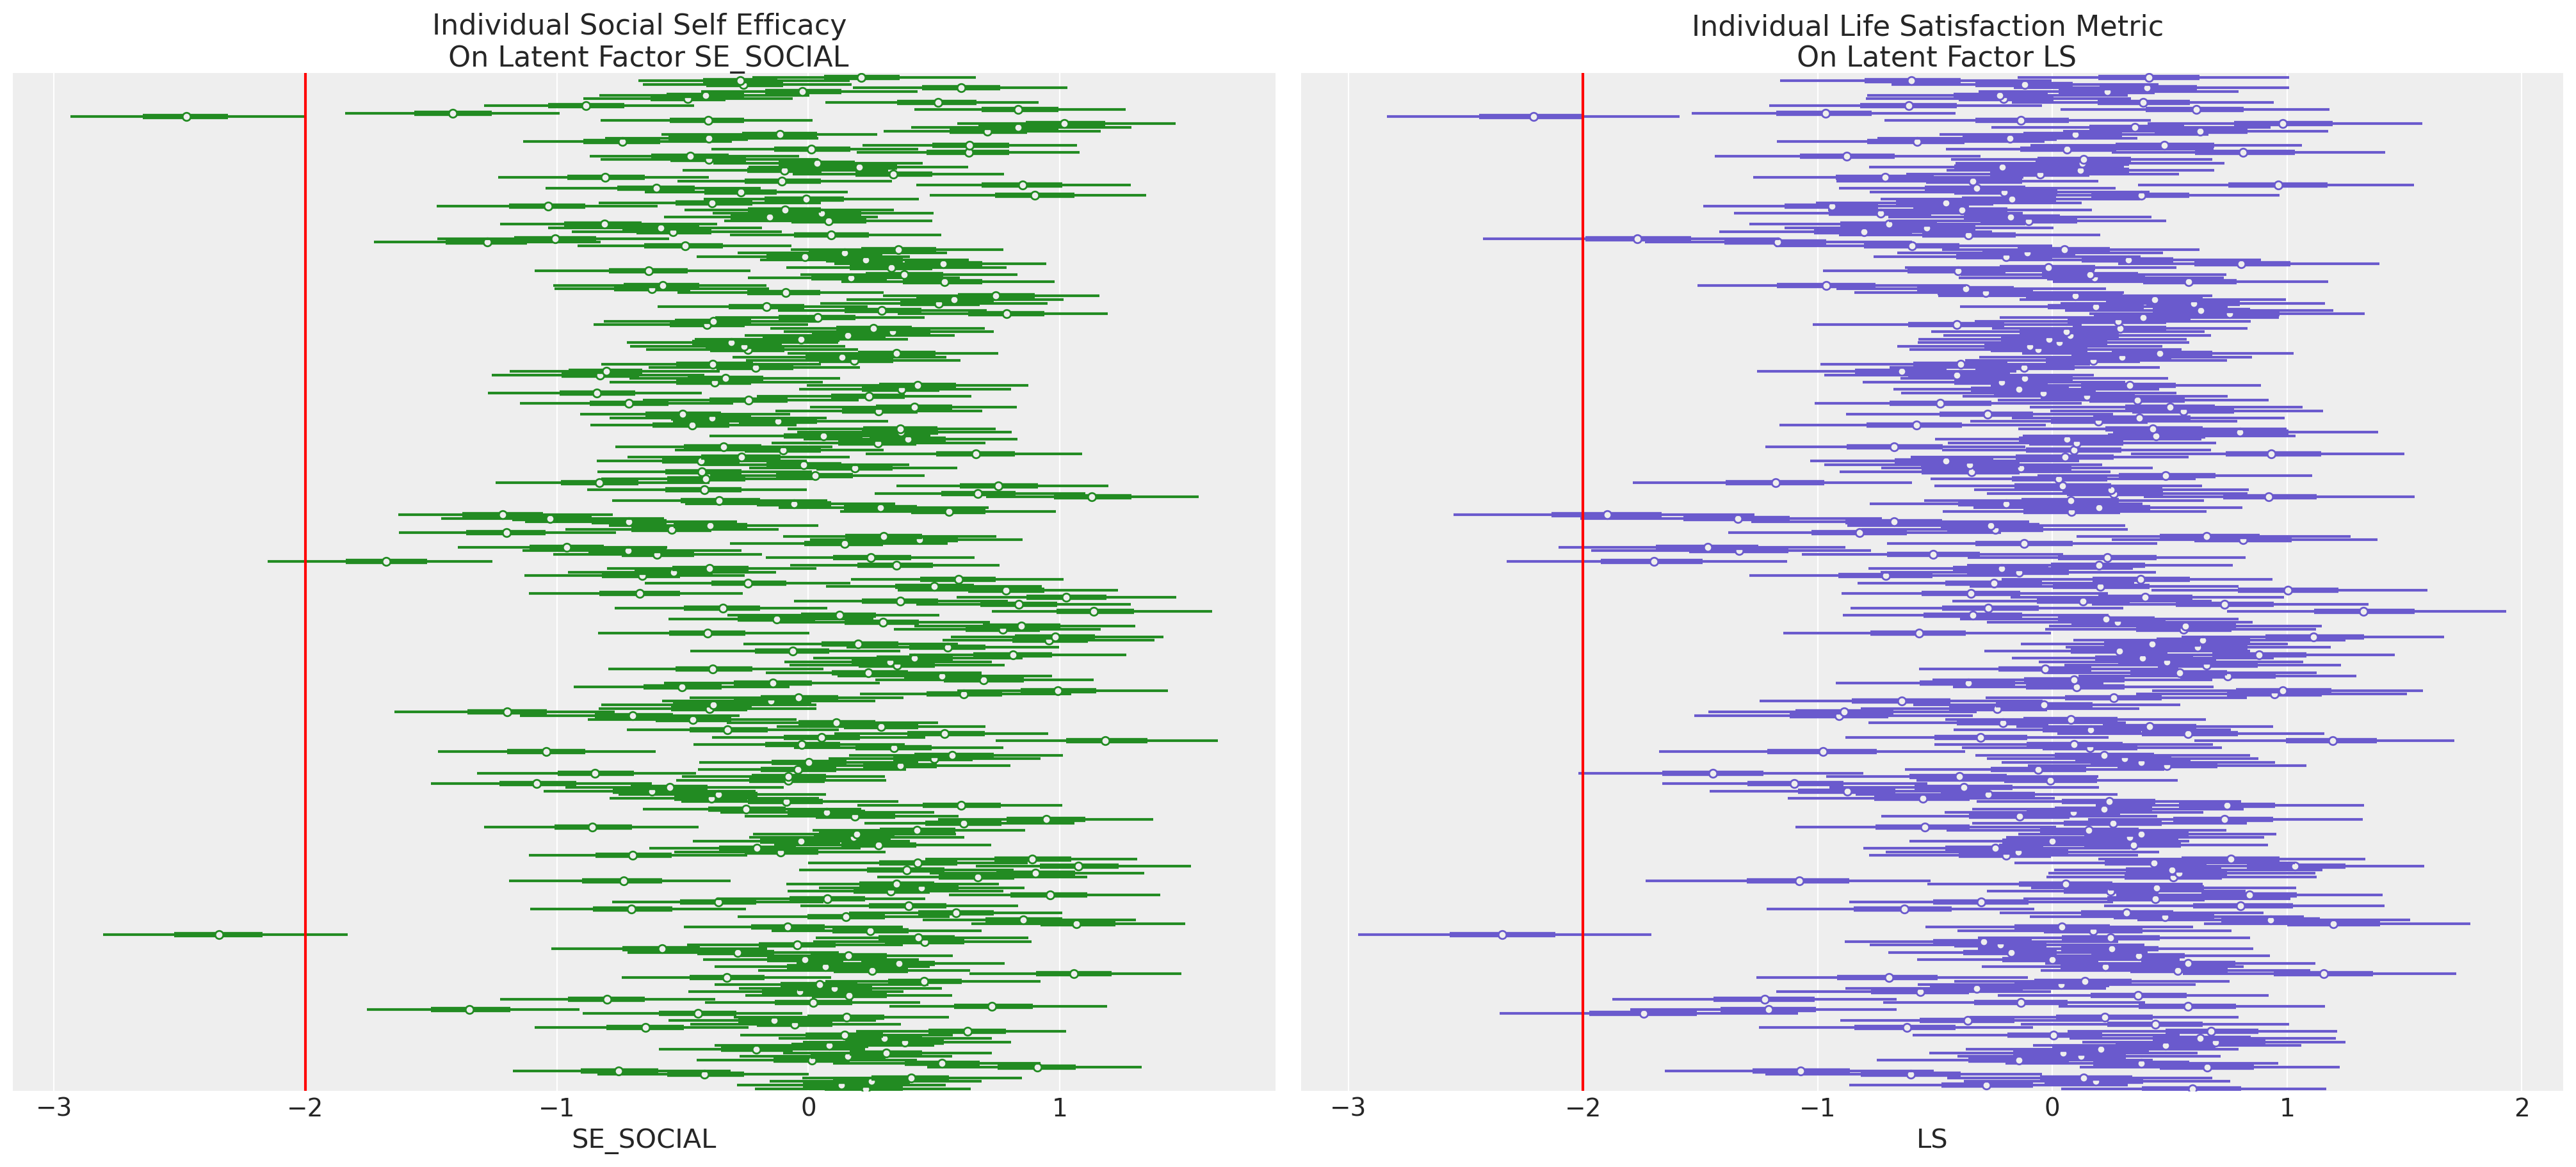

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(20, 9))
axs = axs.flatten()
ax1 = axs[0]
ax2 = axs[1]
az.plot_forest(
    idata,
    var_names=["ksi"],
    combined=True,
    ax=ax1,
    colors="forestgreen",
    coords={"latent": ["SE_SOC"]},
)
az.plot_forest(
    idata, var_names=["ksi"], combined=True, ax=ax2, colors="slateblue", coords={"latent": ["LS"]}
)
ax1.set_yticklabels([])
ax1.set_xlabel("SE_SOCIAL")
ax2.set_yticklabels([])
ax2.set_xlabel("LS")
ax1.axvline(-2, color="red")
ax2.axvline(-2, color="red")
ax1.set_title("Individual Social Self Efficacy \n On Latent Factor SE_SOCIAL")
ax2.set_title("Individual Life Satisfaction Metric \n On Latent Factor LS")
plt.show();

### Posterior Predictive Checks


/var/folders/__/ng_3_9pn1f11ftyml_qr69vh0000gn/T/ipykernel_45611/3491944590.py:25: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


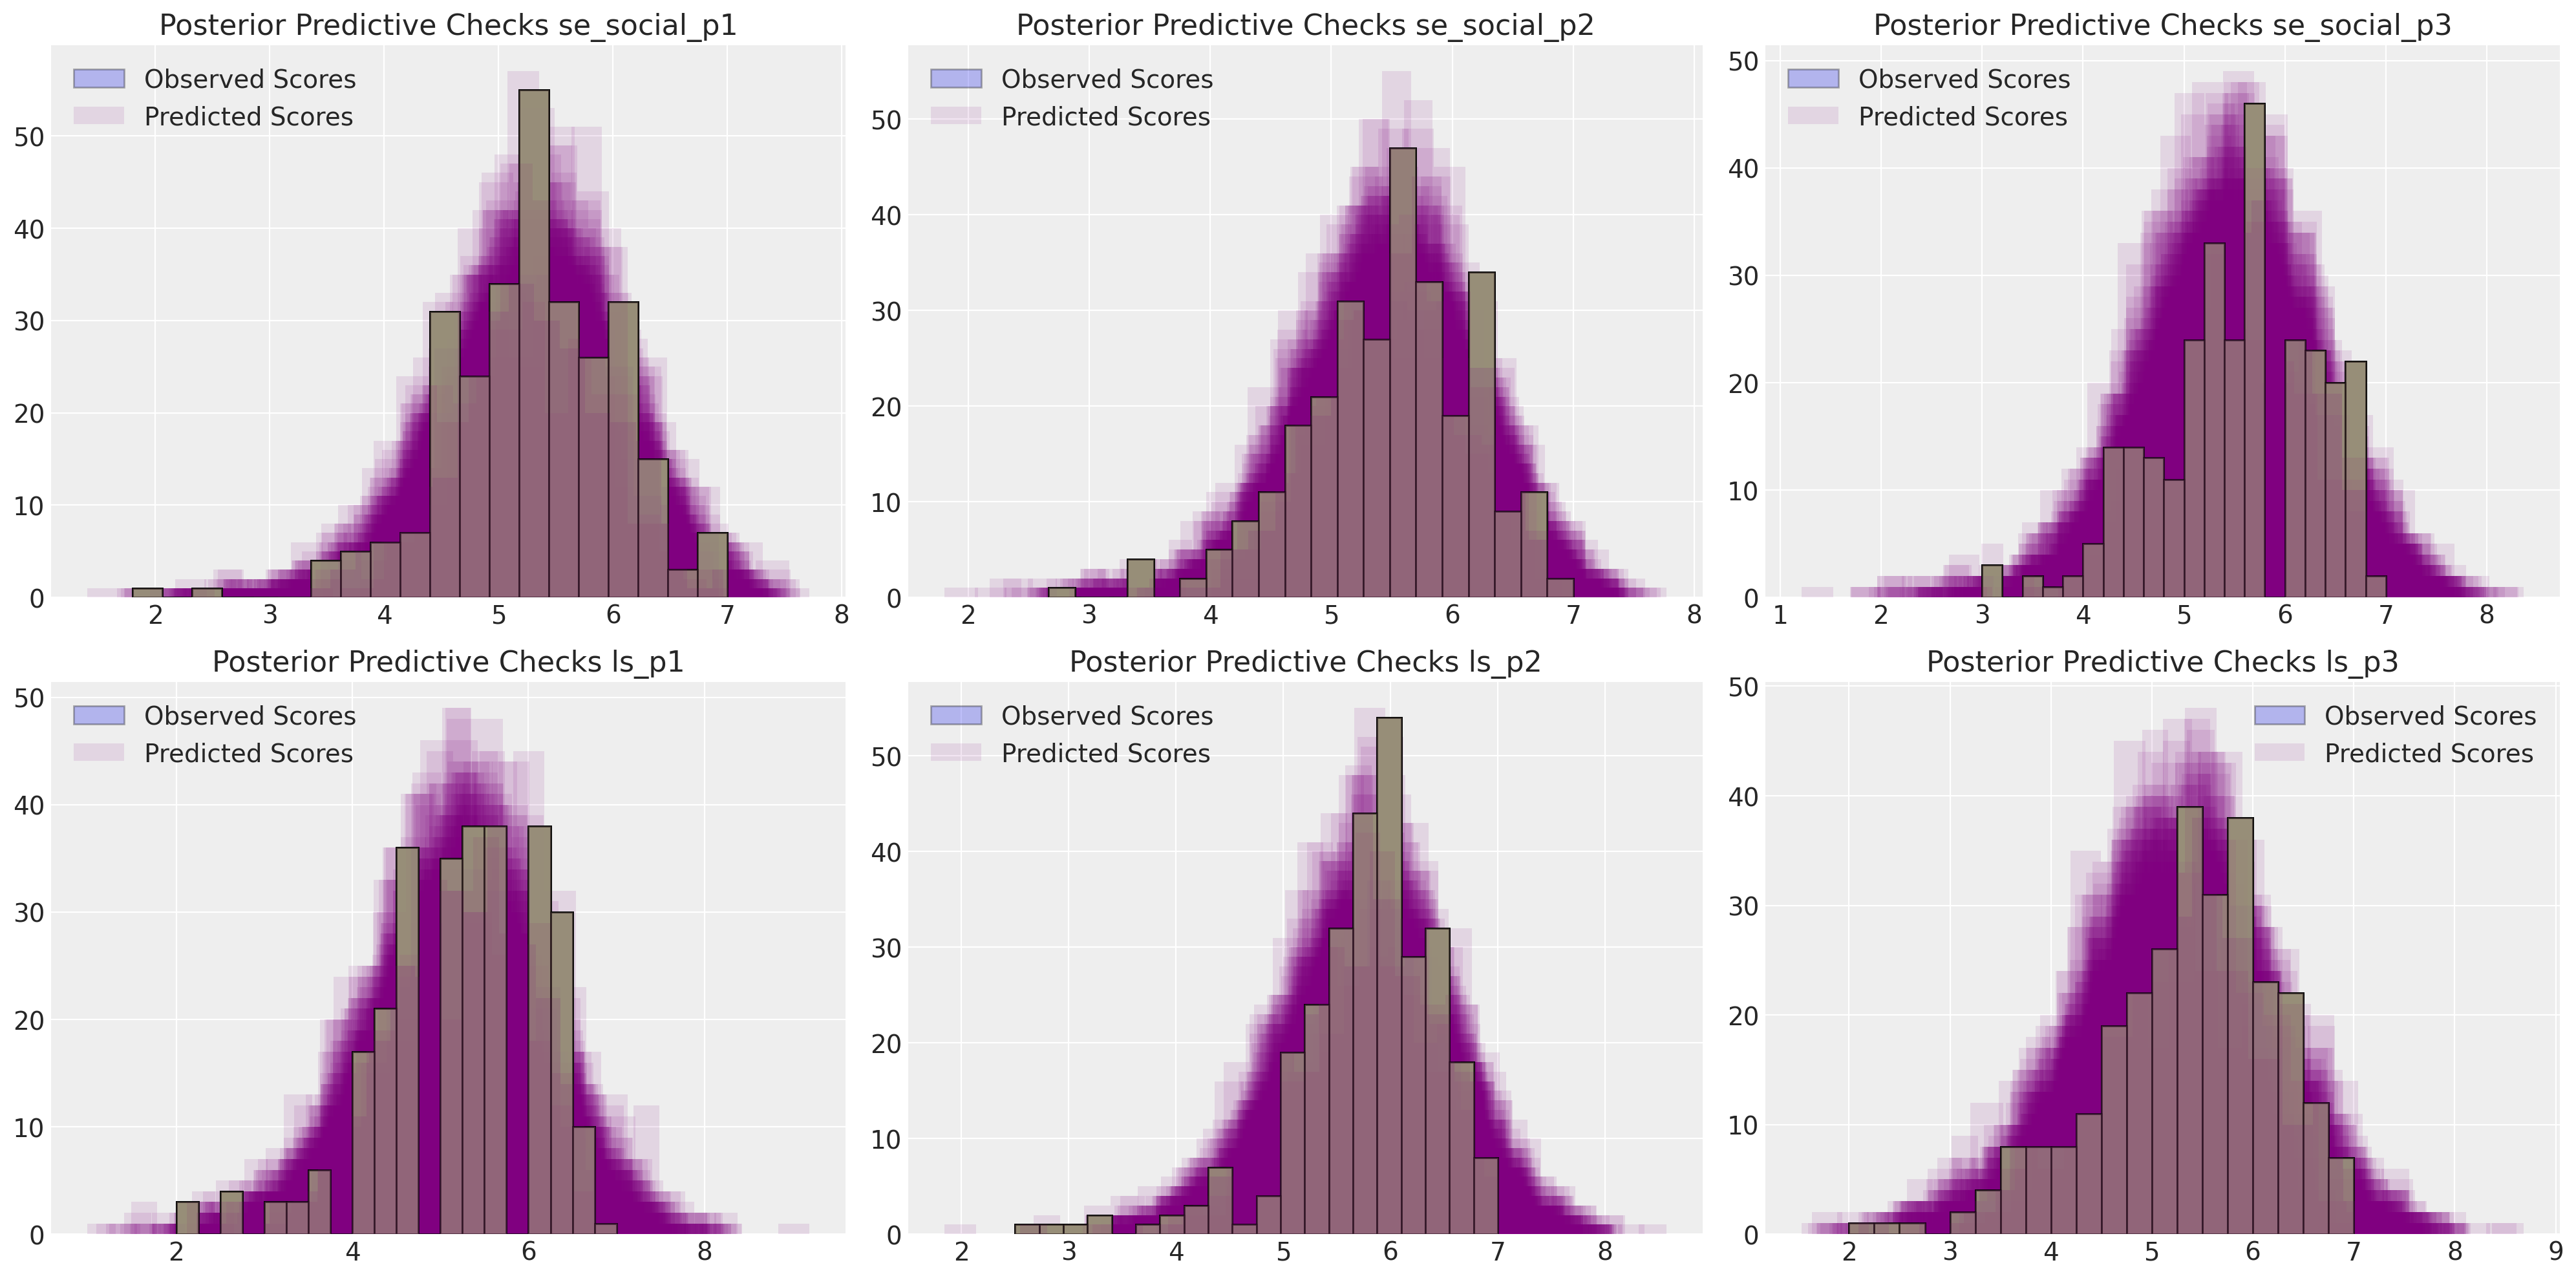

In [10]:
def make_ppc(
    idata,
    samples=100,
    drivers=["se_social_p1", "se_social_p2", "se_social_p3", "ls_p1", "ls_p2", "ls_p3"],
    dims=(2, 3),
):
    fig, axs = plt.subplots(dims[0], dims[1], figsize=(20, 10))
    axs = axs.flatten()
    for i in range(len(drivers)):
        for j in range(samples):
            temp = az.extract(idata["posterior_predictive"].sel({"likelihood_dim_3": i}))[
                "likelihood"
            ].values[:, j]
            temp = pd.DataFrame(temp, columns=["likelihood"])
            if j == 0:
                axs[i].hist(df[drivers[i]], alpha=0.3, ec="black", bins=20, label="Observed Scores")
                axs[i].hist(
                    temp["likelihood"], color="purple", alpha=0.1, bins=20, label="Predicted Scores"
                )
            else:
                axs[i].hist(df[drivers[i]], alpha=0.3, ec="black", bins=20)
                axs[i].hist(temp["likelihood"], color="purple", alpha=0.1, bins=20)
            axs[i].set_title(f"Posterior Predictive Checks {drivers[i]}")
            axs[i].legend()
    plt.tight_layout()
    plt.show()


make_ppc(idata)
del idata

### Intermediate Cross-Loading Model


Compiling...
Compilation time = 0:00:02.689105
Sampling...


  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

Sampling time = 0:00:26.320116
Transforming variables...
Transformation time = 0:00:01.613166
Computing Log Likelihood...
Log Likelihood time = 0:00:00.982108
Sampling: [likelihood]


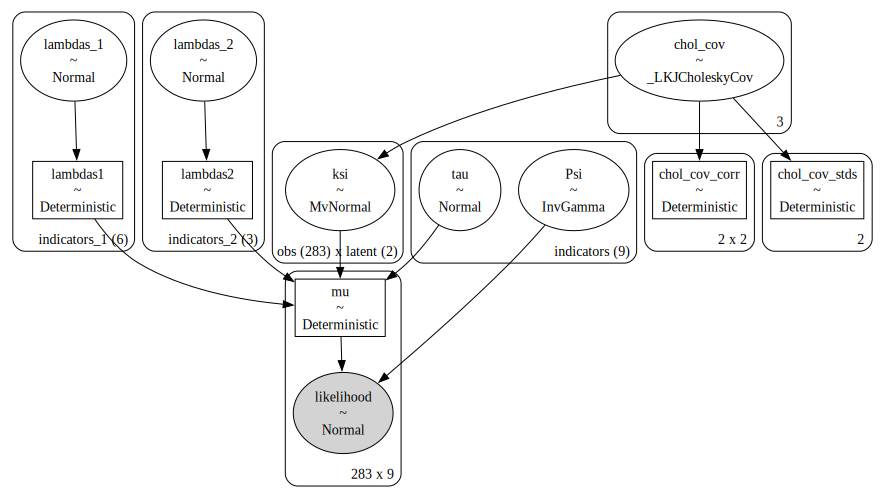

In [11]:
coords = {
    "obs": list(range(len(df))),
    "indicators": [
        "se_social_p1",
        "se_social_p2",
        "se_social_p3",
        "sup_parents_p1",
        "sup_parents_p2",
        "sup_parents_p3",
        "ls_p1",
        "ls_p2",
        "ls_p3",
    ],
    ## Attempt Cross-Loading of two metric types on one factor
    "indicators_1": [
        "se_social_p1",
        "se_social_p2",
        "se_social_p3",
        "sup_parents_p1",
        "sup_parents_p2",
        "sup_parents_p3",
    ],
    "indicators_2": ["ls_p1", "ls_p2", "ls_p3"],
    "latent": ["SE_SOC", "LS"],
}


obs_idx = list(range(len(df)))
with pm.Model(coords=coords) as model:

    Psi = pm.InverseGamma("Psi", 5, 10, dims="indicators")
    lambdas_ = pm.Normal("lambdas_1", 1, 10, dims=("indicators_1"))
    # Force a fixed scale on the factor loadings for factor 1
    lambdas_1 = pm.Deterministic(
        "lambdas1", pt.set_subtensor(lambdas_[0], 1), dims=("indicators_1")
    )
    lambdas_ = pm.Normal("lambdas_2", 1, 10, dims=("indicators_2"))
    # Force a fixed scale on the factor loadings for factor 2
    lambdas_2 = pm.Deterministic(
        "lambdas2", pt.set_subtensor(lambdas_[0], 1), dims=("indicators_2")
    )
    tau = pm.Normal("tau", 3, 10, dims="indicators")
    # Specify covariance structure between latent factors
    kappa = 0
    sd_dist = pm.Exponential.dist(1.0, shape=2)
    chol, _, _ = pm.LKJCholeskyCov("chol_cov", n=2, eta=2, sd_dist=sd_dist, compute_corr=True)
    ksi = pm.MvNormal("ksi", kappa, chol=chol, dims=("obs", "latent"))

    # Construct Observation matrix
    m1 = tau[0] + ksi[obs_idx, 0] * lambdas_1[0]
    m2 = tau[1] + ksi[obs_idx, 0] * lambdas_1[1]
    m3 = tau[2] + ksi[obs_idx, 0] * lambdas_1[2]
    m4 = tau[3] + ksi[obs_idx, 0] * lambdas_1[3]
    m5 = tau[4] + ksi[obs_idx, 0] * lambdas_1[4]
    m6 = tau[5] + ksi[obs_idx, 0] * lambdas_1[5]
    m7 = tau[3] + ksi[obs_idx, 1] * lambdas_2[0]
    m8 = tau[4] + ksi[obs_idx, 1] * lambdas_2[1]
    m9 = tau[5] + ksi[obs_idx, 1] * lambdas_2[2]

    mu = pm.Deterministic("mu", pm.math.stack([m1, m2, m3, m4, m5, m6, m7, m8, m9]).T)
    _ = pm.Normal(
        "likelihood",
        mu,
        Psi,
        observed=df[
            [
                "se_social_p1",
                "se_social_p2",
                "se_social_p3",
                "sup_parents_p1",
                "sup_parents_p2",
                "sup_parents_p3",
                "ls_p1",
                "ls_p2",
                "ls_p3",
            ]
        ].values,
    )

    idata = pm.sample(
        draws=10000,
        nuts_sampler="numpyro",
        target_accept=0.99,
        idata_kwargs={"log_likelihood": True},
        random_seed=114,
    )
    idata.extend(pm.sample_posterior_predictive(idata))

pm.model_to_graphviz(model)

In [12]:
az.summary(idata, var_names=["lambdas1", "lambdas2"])

/Users/nathanielforde/mambaforge/envs/pymc_causal/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/nathanielforde/mambaforge/envs/pymc_causal/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
lambdas1[se_social_p1]    1.000  0.000   1.000    1.000      0.000    0.000   
lambdas1[se_social_p2]    0.928  0.128   0.694    1.172      0.002    0.002   
lambdas1[se_social_p3]    0.854  0.139   0.598    1.121      0.002    0.002   
lambdas1[sup_parents_p1]  2.321  0.289   1.807    2.867      0.008    0.005   
lambdas1[sup_parents_p2]  2.171  0.278   1.684    2.699      0.008    0.005   
lambdas1[sup_parents_p3]  2.334  0.290   1.832    2.898      0.008    0.005   
lambdas2[ls_p1]           1.000  0.000   1.000    1.000      0.000    0.000   
lambdas2[ls_p2]           0.777  0.105   0.589    0.975      0.002    0.002   
lambdas2[ls_p3]           1.080  0.135   0.840    1.335      0.003    0.002   

                          ess_bulk  ess_tail  r_hat  
lambdas1[se_social_p1]     40000.0   40000.0    NaN  
lambdas1[se_social_p2]      3090.0    5423.0    1.0  
lambdas1[se_social_p3]      4600.0    8366.0    1.0  
lambdas1[sup_parents_p1]    1421.0    2736.0    1.0  
lambdas1[sup_parents_p2]    1333.0    2592.0    1.0  
lambdas1[sup_parents_p3]    1442.0    2795.0    1.0  
lambdas2[ls_p1]            40000.0   40000.0    NaN  
lambdas2[ls_p2]             2530.0    4296.0    1.0  
lambdas2[ls_p3]             2271.0    3902.0    1.0

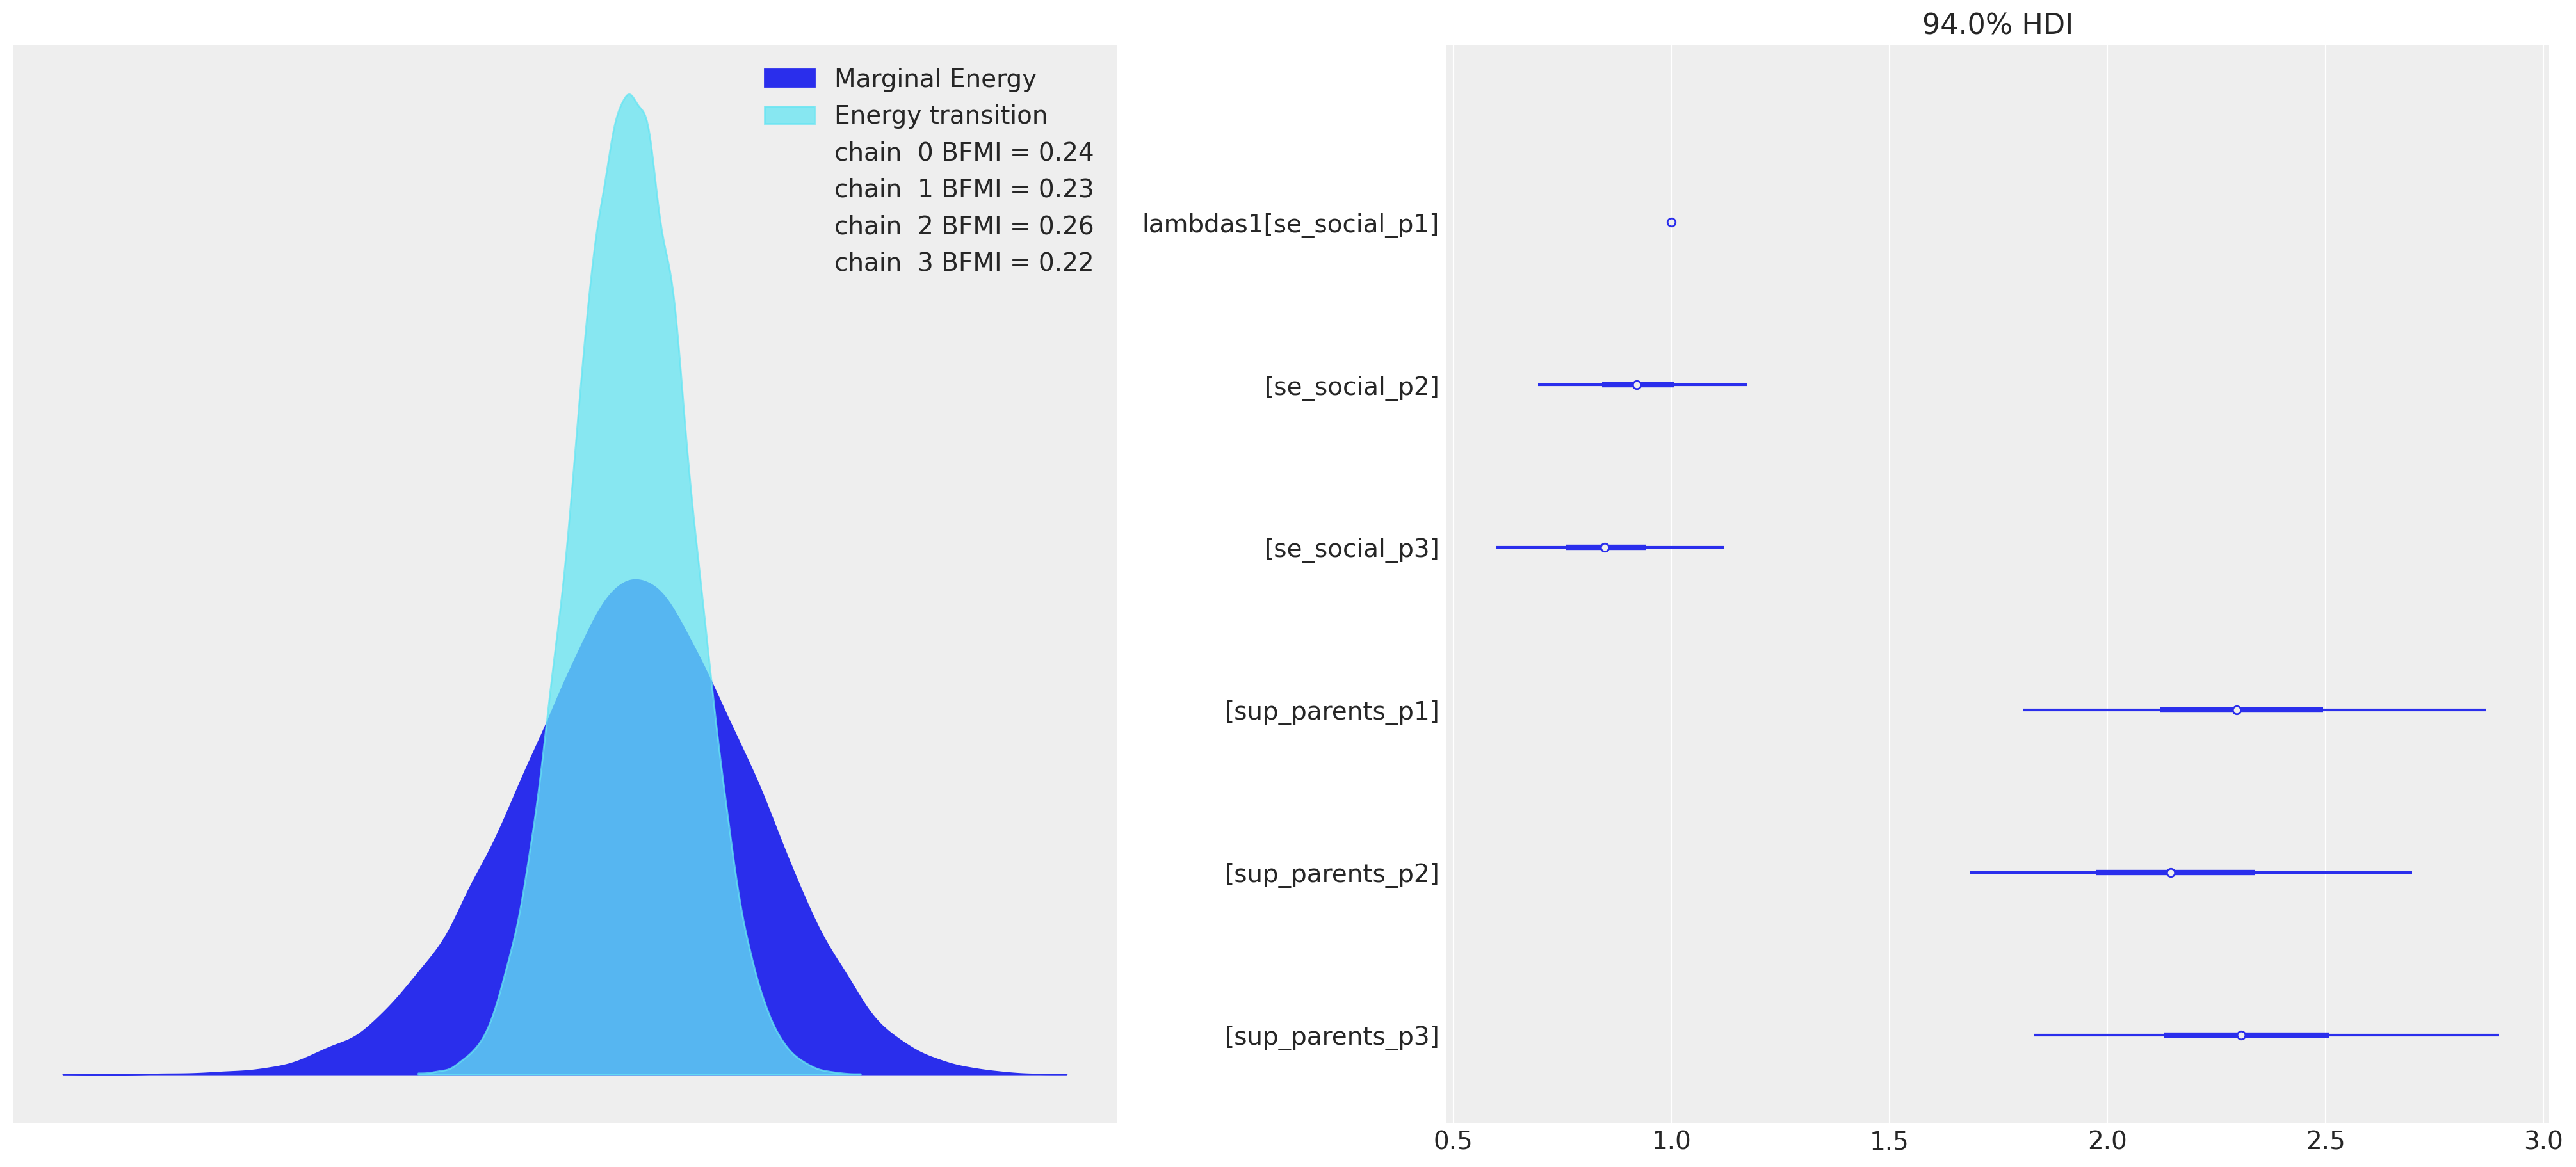

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(20, 9))
axs = axs.flatten()
az.plot_energy(idata, ax=axs[0])
az.plot_forest(idata, var_names=["lambdas1"], combined=True, ax=axs[1]);

## Full Measurement Model

In [14]:
drivers = [
    "se_acad_p1",
    "se_acad_p2",
    "se_acad_p3",
    "se_social_p1",
    "se_social_p2",
    "se_social_p3",
    "sup_friends_p1",
    "sup_friends_p2",
    "sup_friends_p3",
    "sup_parents_p1",
    "sup_parents_p2",
    "sup_parents_p3",
    "ls_p1",
    "ls_p2",
    "ls_p3",
]

coords = {
    "obs": list(range(len(df))),
    "indicators": drivers,
    "indicators_1": ["se_acad_p1", "se_acad_p2", "se_acad_p3"],
    "indicators_2": ["se_social_p1", "se_social_p2", "se_social_p3"],
    "indicators_3": ["sup_friends_p1", "sup_friends_p2", "sup_friends_p3"],
    "indicators_4": ["sup_parents_p1", "sup_parents_p2", "sup_parents_p3"],
    "indicators_5": ["ls_p1", "ls_p2", "ls_p3"],
    "latent": ["SE_ACAD", "SE_SOCIAL", "SUP_F", "SUP_P", "LS"],
    "latent1": ["SE_ACAD", "SE_SOCIAL", "SUP_F", "SUP_P", "LS"],
}

obs_idx = list(range(len(df)))
with pm.Model(coords=coords) as model:

    Psi = pm.InverseGamma("Psi", 5, 10, dims="indicators")
    lambdas_ = pm.Normal("lambdas_1", 1, 10, dims=("indicators_1"))
    lambdas_1 = pm.Deterministic(
        "lambdas1", pt.set_subtensor(lambdas_[0], 1), dims=("indicators_1")
    )
    lambdas_ = pm.Normal("lambdas_2", 1, 10, dims=("indicators_2"))
    lambdas_2 = pm.Deterministic(
        "lambdas2", pt.set_subtensor(lambdas_[0], 1), dims=("indicators_2")
    )
    lambdas_ = pm.Normal("lambdas_3", 1, 10, dims=("indicators_3"))
    lambdas_3 = pm.Deterministic(
        "lambdas3", pt.set_subtensor(lambdas_[0], 1), dims=("indicators_3")
    )
    lambdas_ = pm.Normal("lambdas_4", 1, 10, dims=("indicators_4"))
    lambdas_4 = pm.Deterministic(
        "lambdas4", pt.set_subtensor(lambdas_[0], 1), dims=("indicators_4")
    )
    lambdas_ = pm.Normal("lambdas_5", 1, 10, dims=("indicators_5"))
    lambdas_5 = pm.Deterministic(
        "lambdas5", pt.set_subtensor(lambdas_[0], 1), dims=("indicators_5")
    )
    tau = pm.Normal("tau", 3, 10, dims="indicators")
    kappa = 0
    sd_dist = pm.Exponential.dist(1.0, shape=5)
    chol, _, _ = pm.LKJCholeskyCov("chol_cov", n=5, eta=2, sd_dist=sd_dist, compute_corr=True)
    cov = pm.Deterministic("cov", chol.dot(chol.T), dims=("latent", "latent1"))
    ksi = pm.MvNormal("ksi", kappa, chol=chol, dims=("obs", "latent"))

    m0 = tau[0] + ksi[obs_idx, 0] * lambdas_1[0]
    m1 = tau[1] + ksi[obs_idx, 0] * lambdas_1[1]
    m2 = tau[2] + ksi[obs_idx, 0] * lambdas_1[2]
    m3 = tau[3] + ksi[obs_idx, 1] * lambdas_2[0]
    m4 = tau[4] + ksi[obs_idx, 1] * lambdas_2[1]
    m5 = tau[5] + ksi[obs_idx, 1] * lambdas_2[2]
    m6 = tau[6] + ksi[obs_idx, 2] * lambdas_3[0]
    m7 = tau[7] + ksi[obs_idx, 2] * lambdas_3[1]
    m8 = tau[8] + ksi[obs_idx, 2] * lambdas_3[2]
    m9 = tau[9] + ksi[obs_idx, 3] * lambdas_4[0]
    m10 = tau[10] + ksi[obs_idx, 3] * lambdas_4[1]
    m11 = tau[11] + ksi[obs_idx, 3] * lambdas_4[2]
    m12 = tau[12] + ksi[obs_idx, 4] * lambdas_5[0]
    m13 = tau[13] + ksi[obs_idx, 4] * lambdas_5[1]
    m14 = tau[14] + ksi[obs_idx, 4] * lambdas_5[2]

    mu = pm.Deterministic(
        "mu", pm.math.stack([m0, m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, m11, m12, m13, m14]).T
    )
    _ = pm.Normal("likelihood", mu, Psi, observed=df[drivers].values)

    idata_mm = pm.sample(
        draws=10000,
        nuts_sampler="numpyro",
        target_accept=0.98,
        tune=1000,
        idata_kwargs={"log_likelihood": True},
        random_seed=100,
    )
    idata_mm.extend(pm.sample_posterior_predictive(idata_mm))

Compiling...
Compilation time = 0:00:02.688486
Sampling...


  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

Sampling time = 0:04:26.878496
Transforming variables...
Transformation time = 0:00:03.178875
Computing Log Likelihood...
Log Likelihood time = 0:00:01.698431
Sampling: [likelihood]


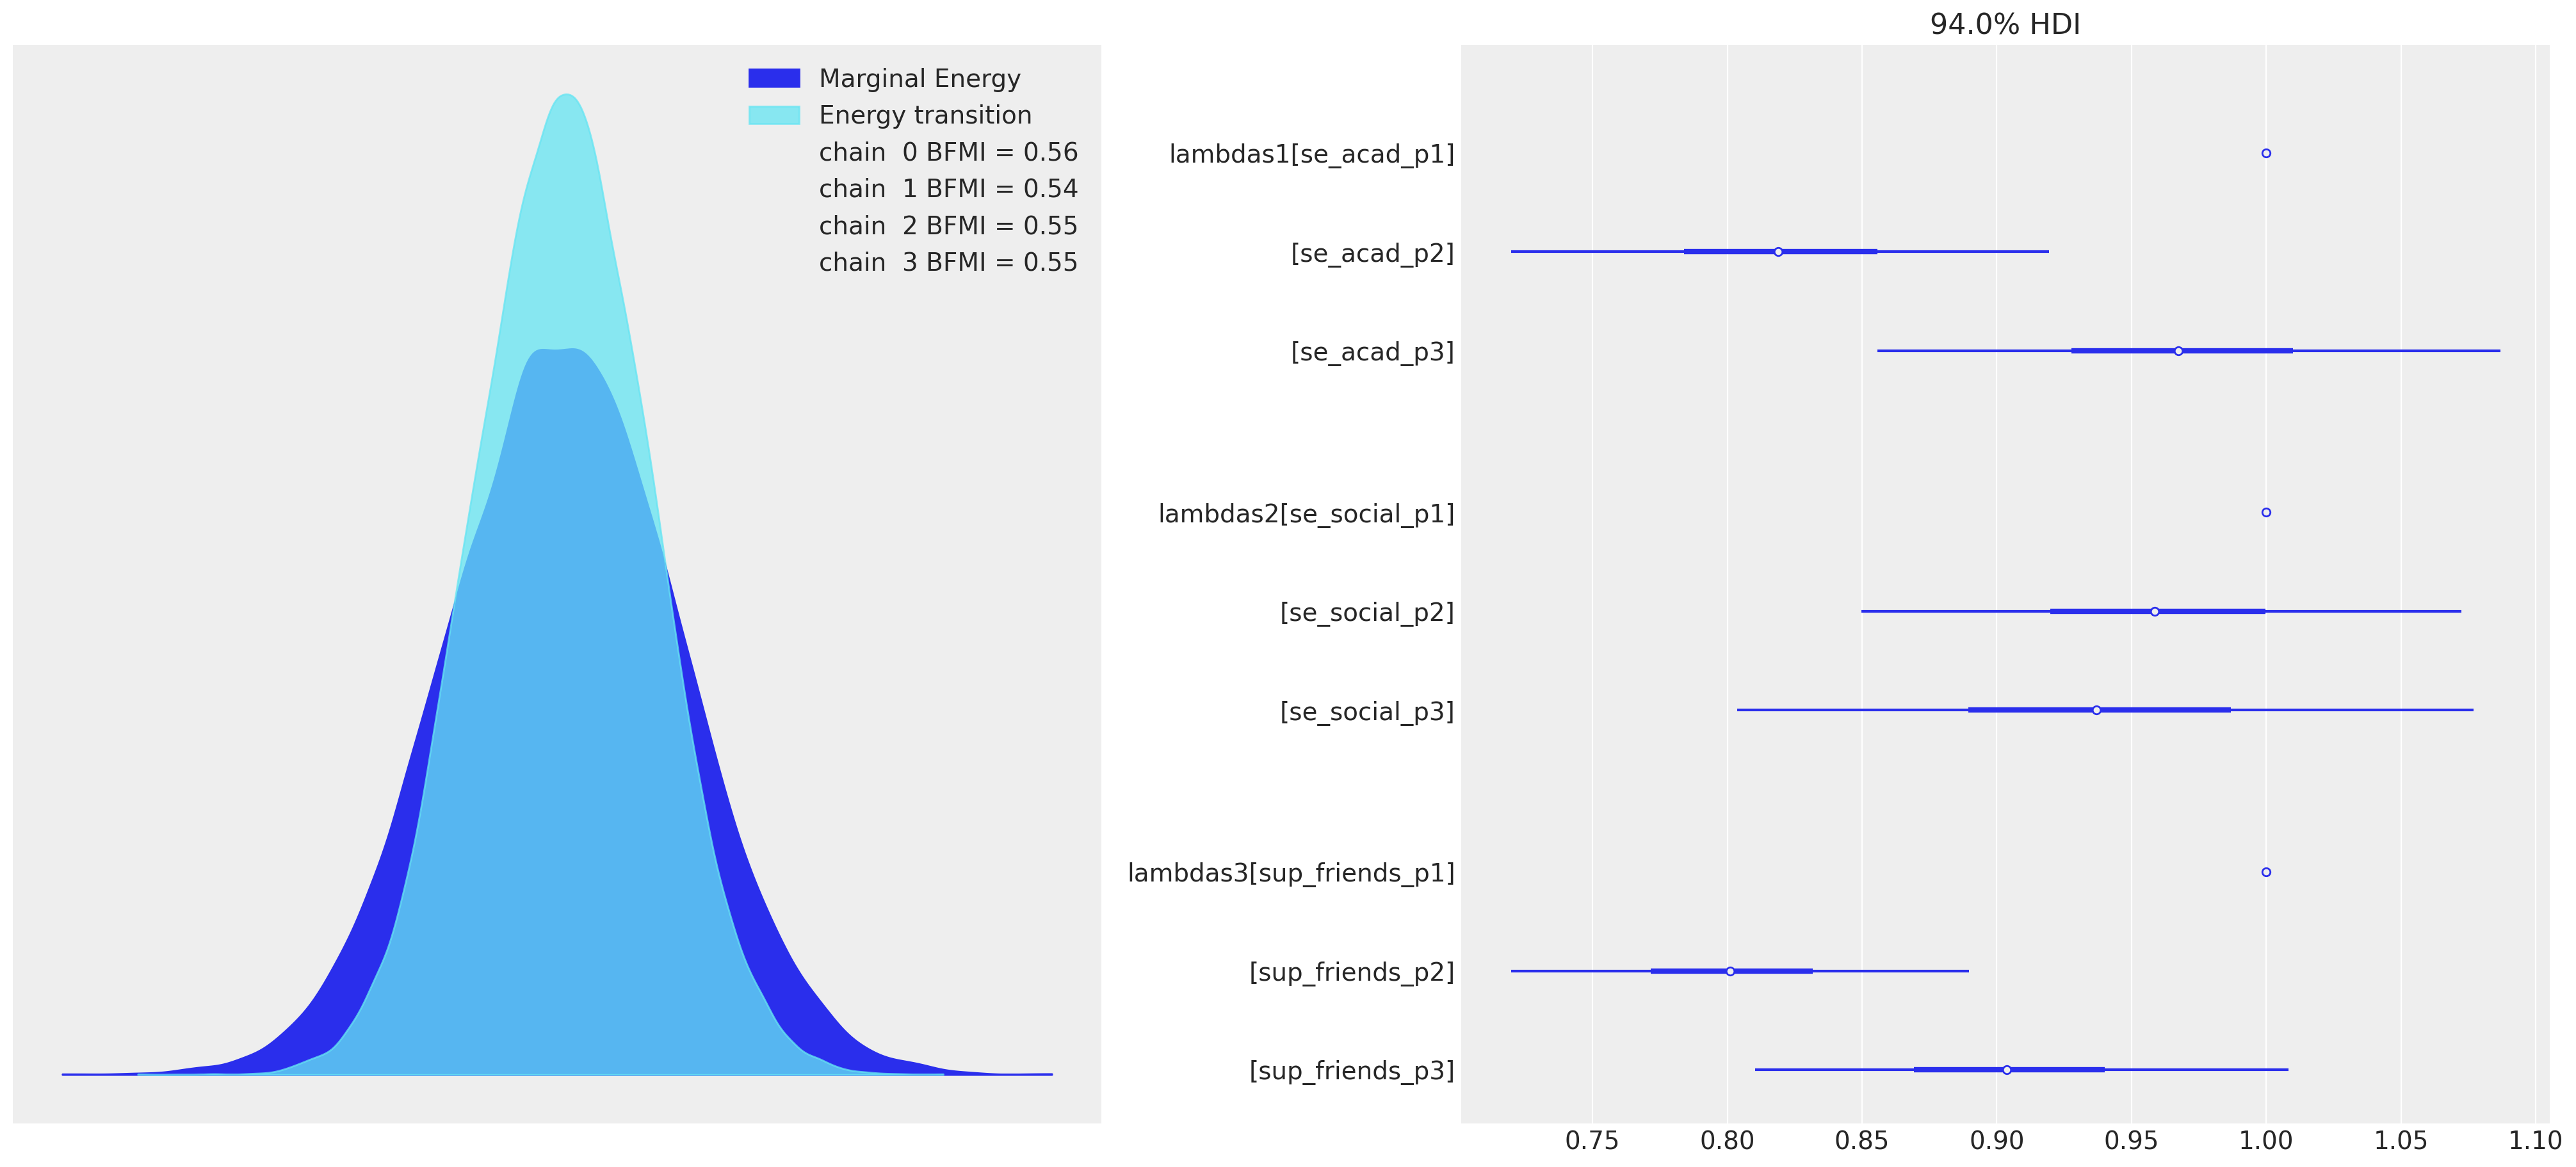

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(20, 9))
axs = axs.flatten()
az.plot_energy(idata_mm, ax=axs[0])
az.plot_forest(idata_mm, var_names=["lambdas1", "lambdas2", "lambdas3"], combined=True, ax=axs[1]);

In [16]:
def get_posterior_resids(idata, samples=100, metric="cov"):
    resids = []
    for i in range(100):
        if metric == "cov":
            model_cov = pd.DataFrame(
                az.extract(idata["posterior_predictive"])["likelihood"][:, :, i]
            ).cov()
            obs_cov = df[drivers].cov()
        else:
            model_cov = pd.DataFrame(
                az.extract(idata["posterior_predictive"])["likelihood"][:, :, i]
            ).corr()
            obs_cov = df[drivers].corr()
        model_cov.index = obs_cov.index
        model_cov.columns = obs_cov.columns
        residuals = model_cov - obs_cov
        resids.append(residuals.values.flatten())

    residuals_posterior = pd.DataFrame(pd.DataFrame(resids).mean().values.reshape(15, 15))
    residuals_posterior.index = obs_cov.index
    residuals_posterior.columns = obs_cov.index
    return residuals_posterior


residuals_posterior_cov = get_posterior_resids(idata_mm, 2500)
residuals_posterior_corr = get_posterior_resids(idata_mm, 2500, metric="corr")

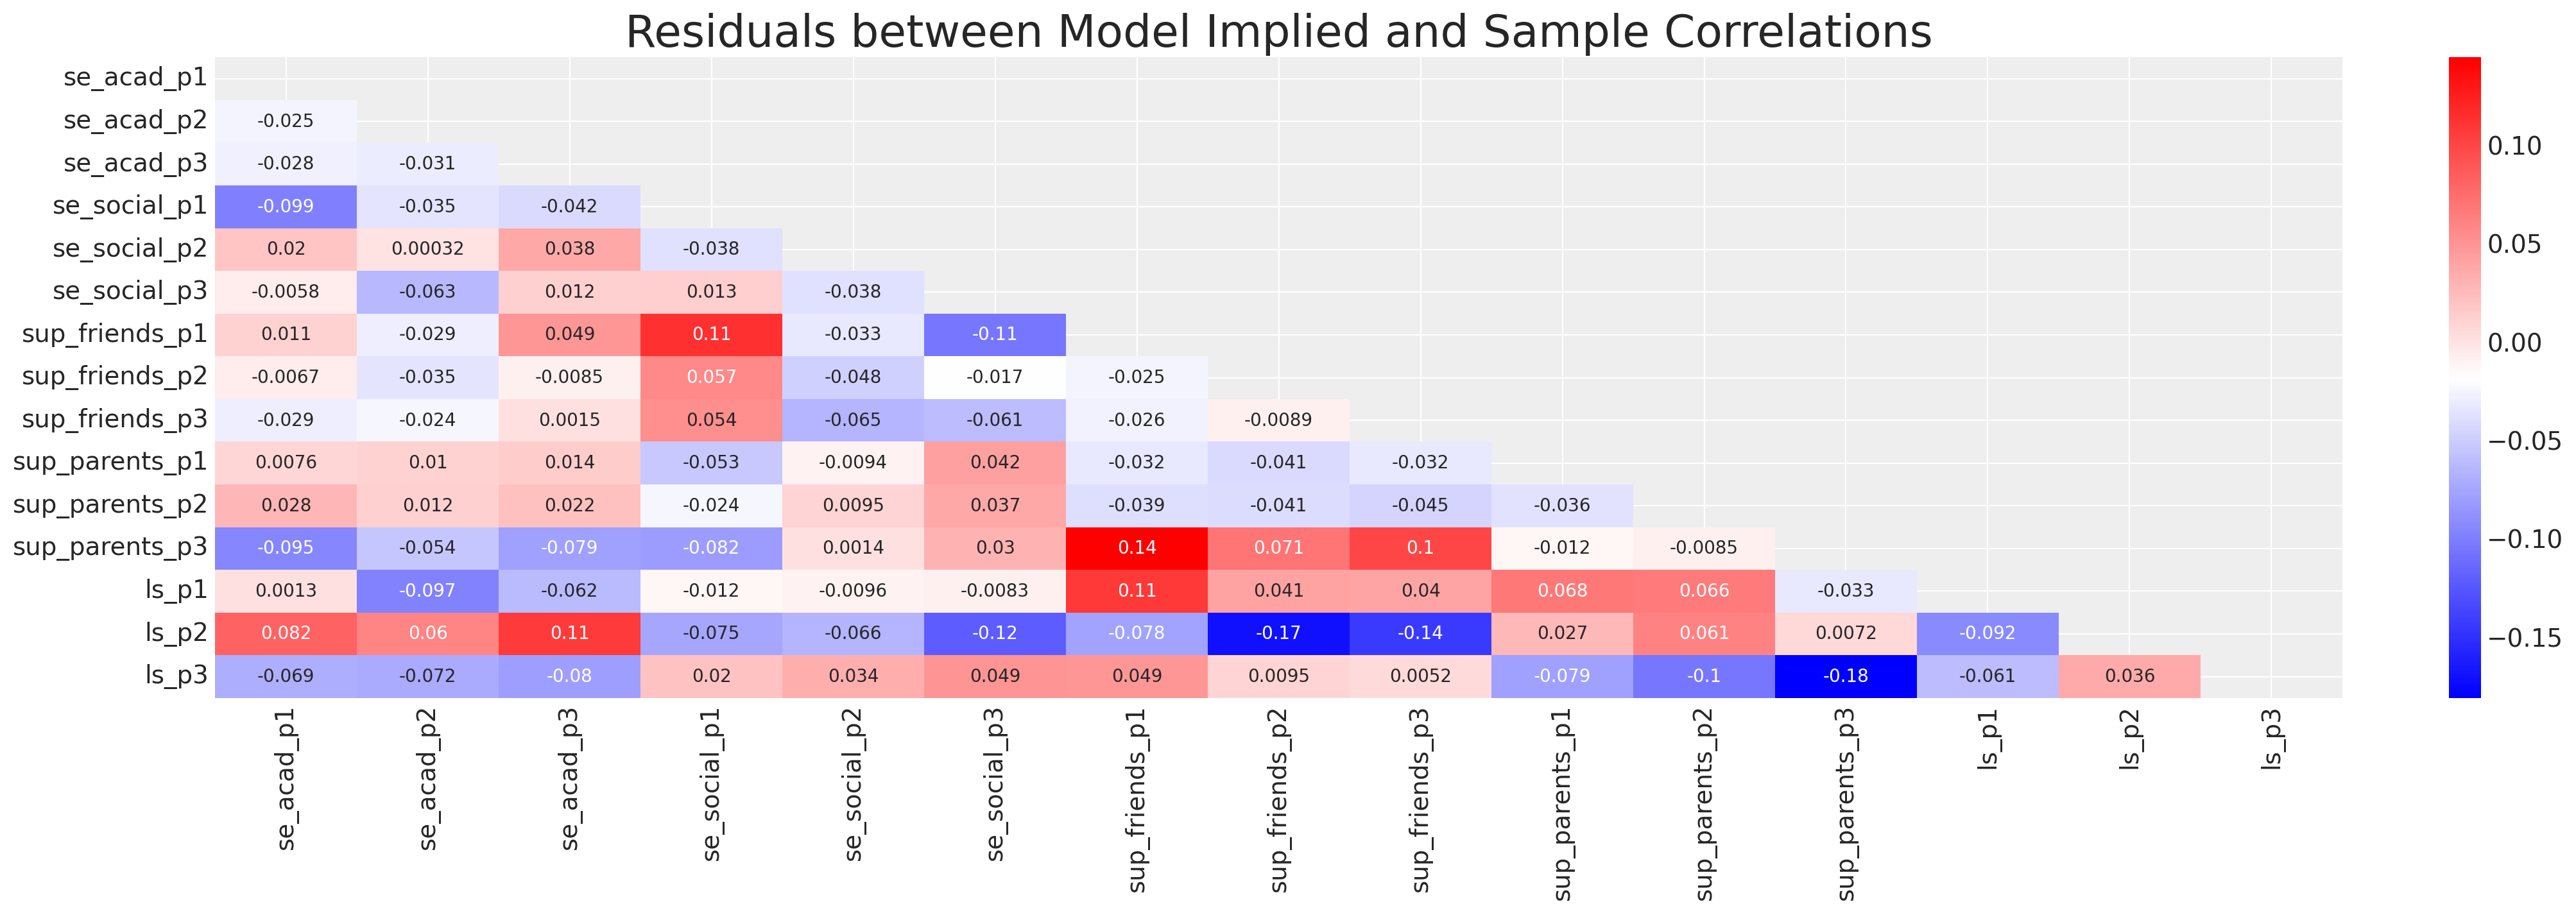

In [17]:
fig, ax = plt.subplots(figsize=(20, 7))
mask = np.triu(np.ones_like(residuals_posterior_corr, dtype=bool))
ax = sns.heatmap(residuals_posterior_corr, annot=True, cmap="bwr", mask=mask)
ax.set_title("Residuals between Model Implied and Sample Correlations", fontsize=25);

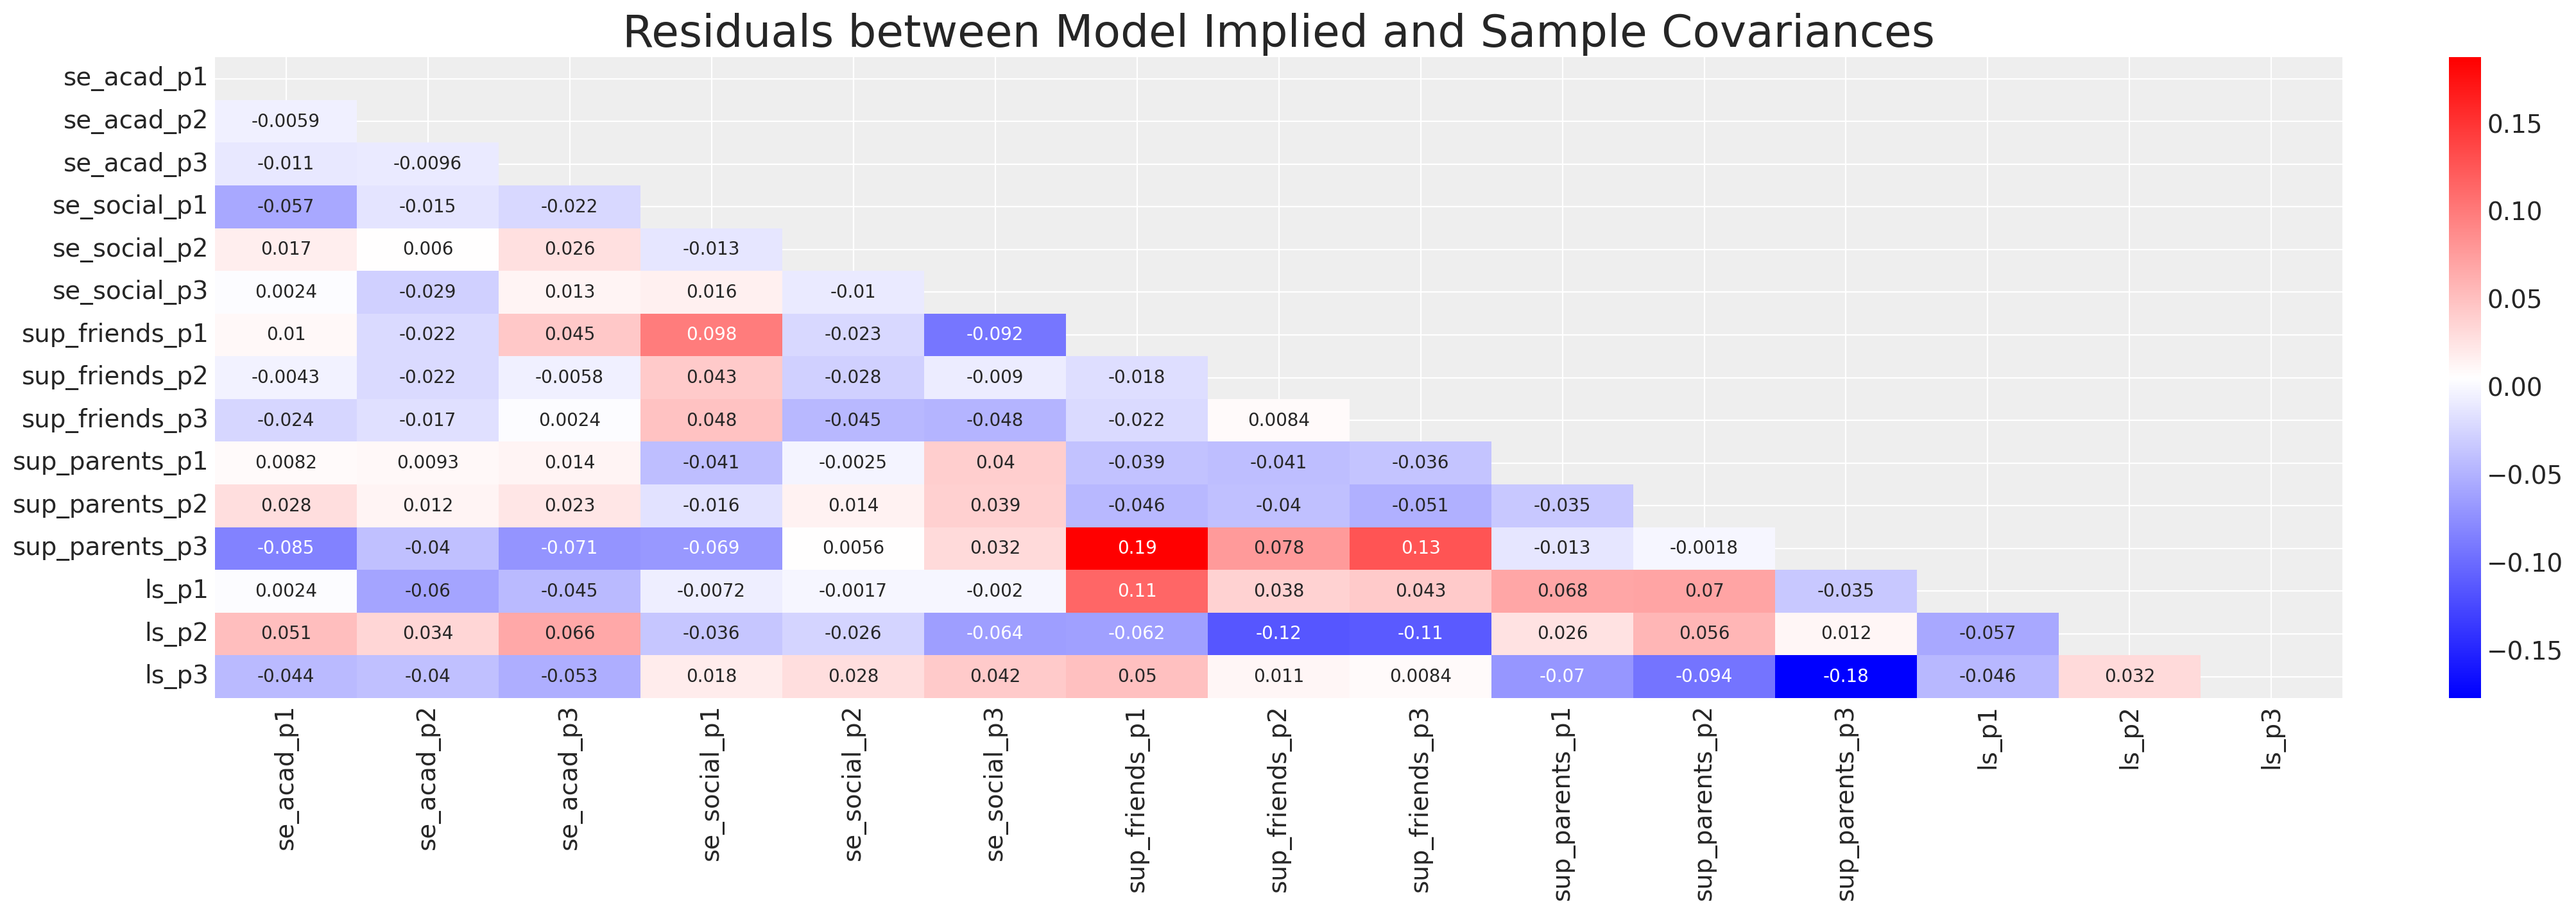

In [18]:
fig, ax = plt.subplots(figsize=(20, 7))
ax = sns.heatmap(residuals_posterior_cov, annot=True, cmap="bwr", mask=mask)
ax.set_title("Residuals between Model Implied and Sample Covariances", fontsize=25);

/var/folders/__/ng_3_9pn1f11ftyml_qr69vh0000gn/T/ipykernel_45611/3491944590.py:25: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


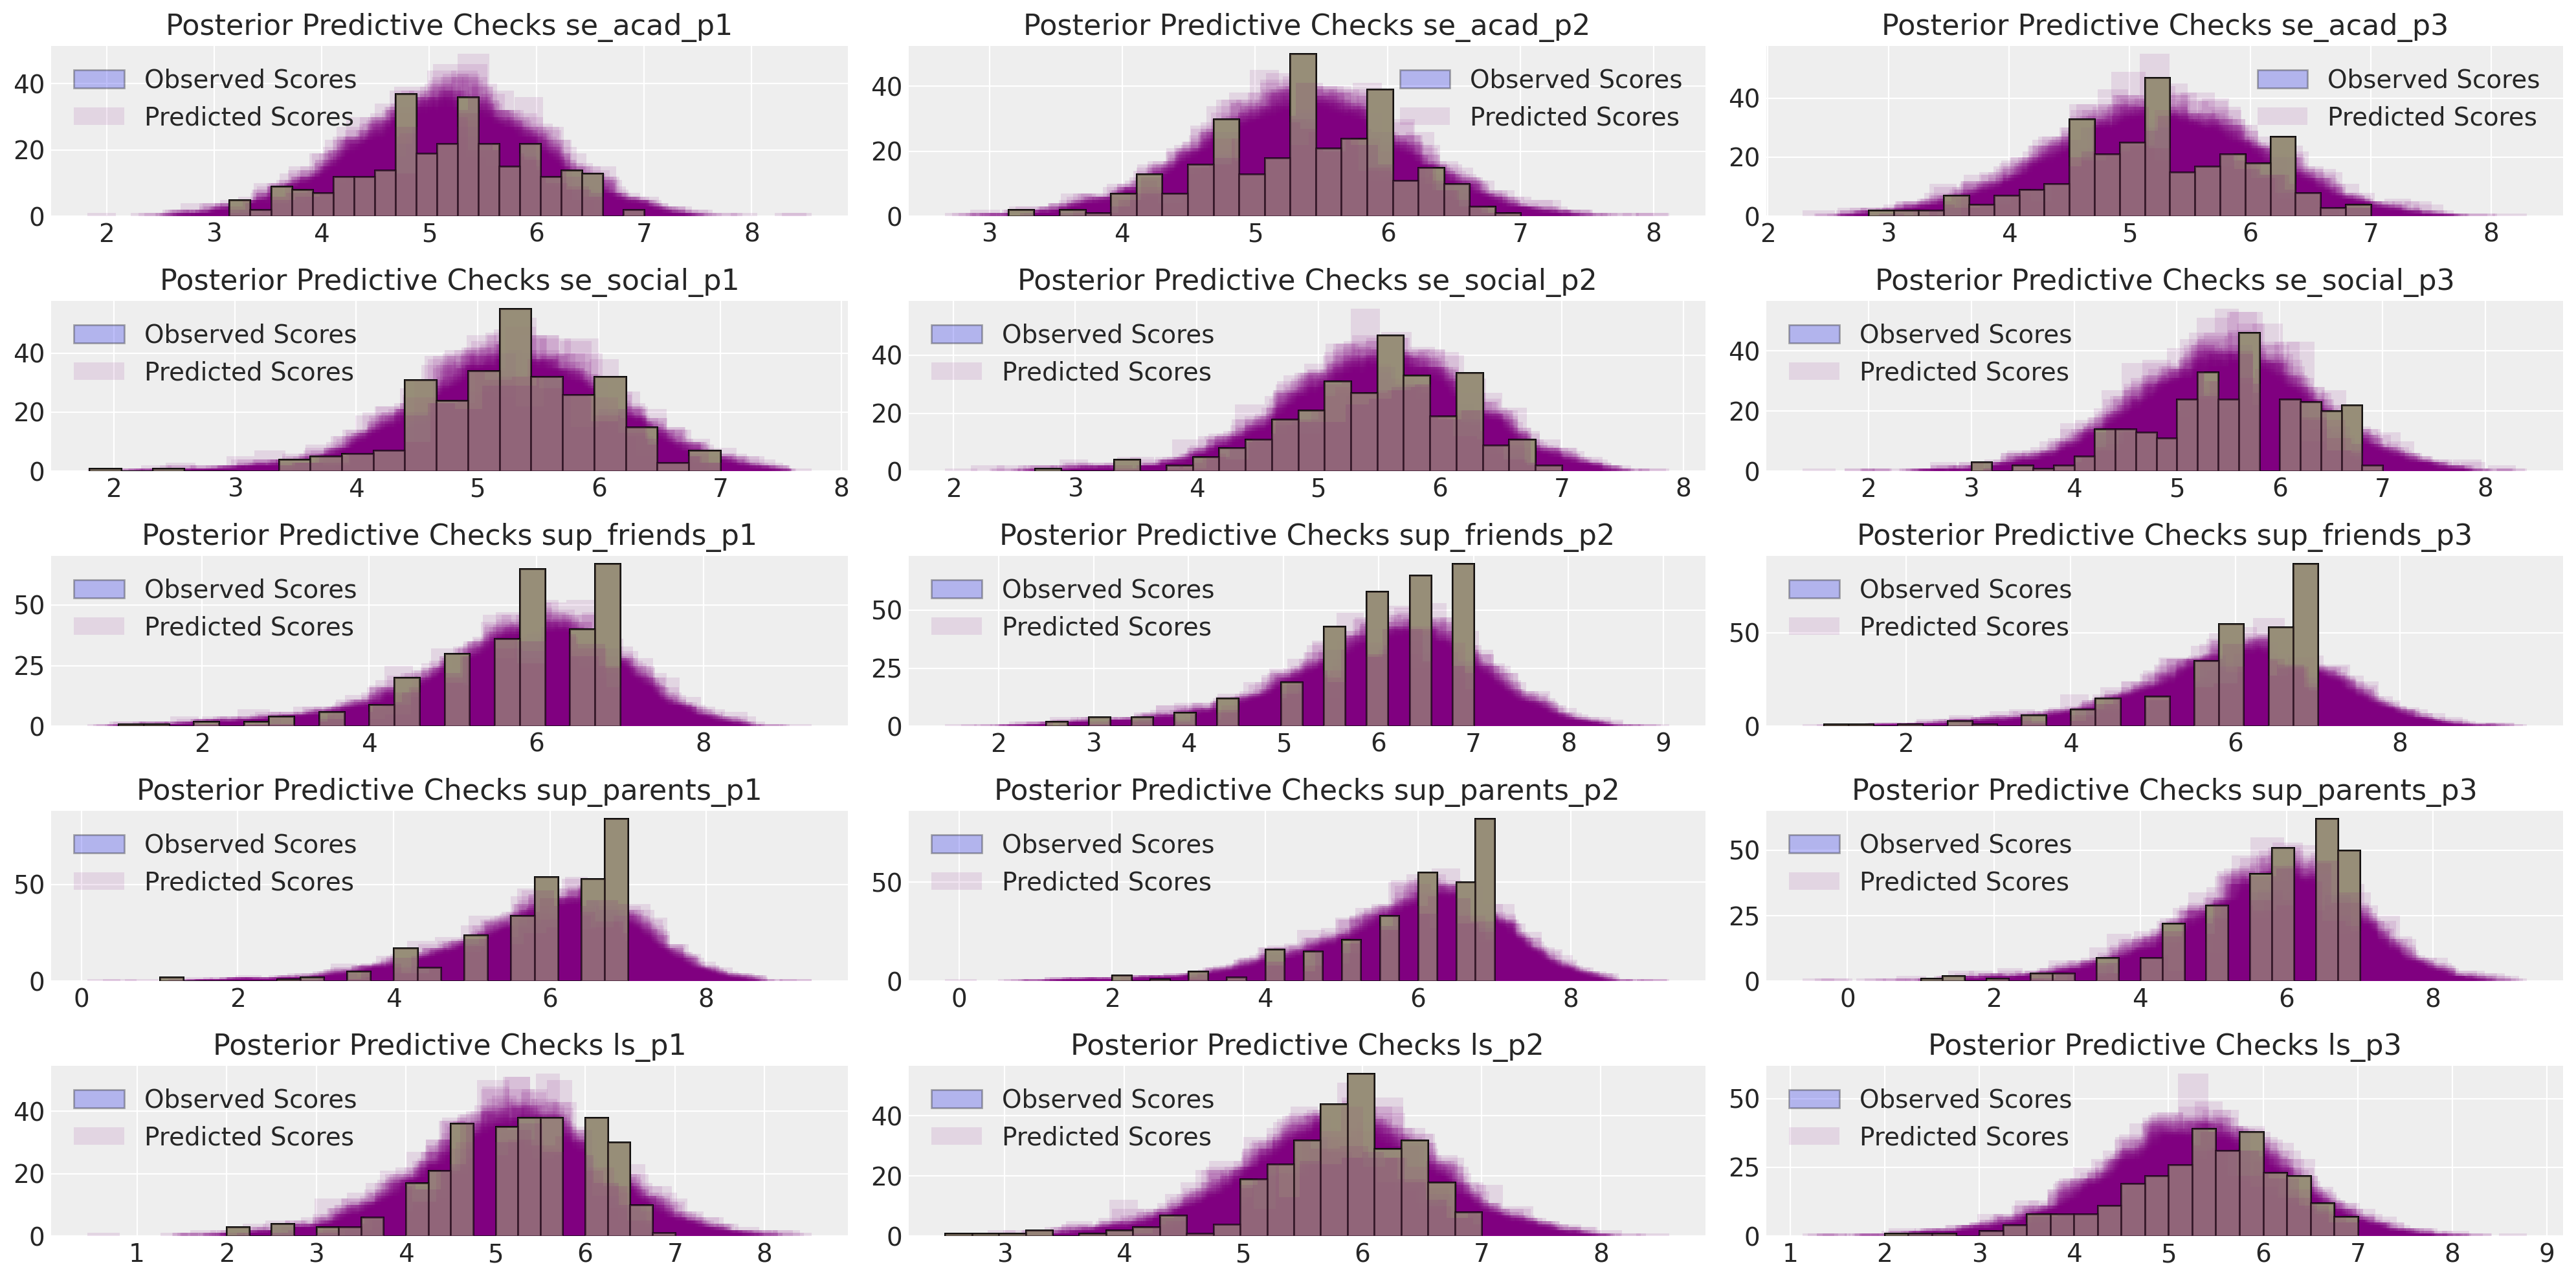

In [19]:
make_ppc(idata_mm, 100, drivers=residuals_posterior_cov.columns, dims=(5, 3));

## Bayesian Structural Equation Models

In [20]:
drivers = [
    "se_acad_p1",
    "se_acad_p2",
    "se_acad_p3",
    "se_social_p1",
    "se_social_p2",
    "se_social_p3",
    "sup_friends_p1",
    "sup_friends_p2",
    "sup_friends_p3",
    "sup_parents_p1",
    "sup_parents_p2",
    "sup_parents_p3",
    "ls_p1",
    "ls_p2",
    "ls_p3",
]


def make_indirect_sem(priors):

    coords = {
        "obs": list(range(len(df))),
        "indicators": drivers,
        "indicators_1": ["se_acad_p1", "se_acad_p2", "se_acad_p3"],
        "indicators_2": ["se_social_p1", "se_social_p2", "se_social_p3"],
        "indicators_3": ["sup_friends_p1", "sup_friends_p2", "sup_friends_p3"],
        "indicators_4": ["sup_parents_p1", "sup_parents_p2", "sup_parents_p3"],
        "indicators_5": ["ls_p1", "ls_p2", "ls_p3"],
        "latent": ["SUP_F", "SUP_P"],
        "latent1": ["SUP_F", "SUP_P"],
        "latent_regression": ["SUP_F->SE_ACAD", "SUP_P->SE_ACAD", "SUP_F->SE_SOC", "SUP_P->SE_SOC"],
        "regression": ["SE_ACAD", "SE_SOCIAL", "SUP_F", "SUP_P"],
    }

    obs_idx = list(range(len(df)))
    with pm.Model(coords=coords) as model:

        Psi = pm.InverseGamma("Psi", 5, 10, dims="indicators")
        lambdas_ = pm.Normal(
            "lambdas_1", priors["lambda"][0], priors["lambda"][1], dims=("indicators_1")
        )
        lambdas_1 = pm.Deterministic(
            "lambdas1", pt.set_subtensor(lambdas_[0], 1), dims=("indicators_1")
        )
        lambdas_ = pm.Normal(
            "lambdas_2", priors["lambda"][0], priors["lambda"][1], dims=("indicators_2")
        )
        lambdas_2 = pm.Deterministic(
            "lambdas2", pt.set_subtensor(lambdas_[0], 1), dims=("indicators_2")
        )
        lambdas_ = pm.Normal(
            "lambdas_3", priors["lambda"][0], priors["lambda"][1], dims=("indicators_3")
        )
        lambdas_3 = pm.Deterministic(
            "lambdas3", pt.set_subtensor(lambdas_[0], 1), dims=("indicators_3")
        )
        lambdas_ = pm.Normal(
            "lambdas_4", priors["lambda"][0], priors["lambda"][1], dims=("indicators_4")
        )
        lambdas_4 = pm.Deterministic(
            "lambdas4", pt.set_subtensor(lambdas_[0], 1), dims=("indicators_4")
        )
        lambdas_ = pm.Normal(
            "lambdas_5", priors["lambda"][0], priors["lambda"][1], dims=("indicators_5")
        )
        lambdas_5 = pm.Deterministic(
            "lambdas5", pt.set_subtensor(lambdas_[0], 1), dims=("indicators_5")
        )
        tau = pm.Normal("tau", 3, 10, dims="indicators")
        kappa = 0
        sd_dist = pm.Exponential.dist(1.0, shape=2)
        chol, _, _ = pm.LKJCholeskyCov(
            "chol_cov", n=2, eta=priors["eta"], sd_dist=sd_dist, compute_corr=True
        )
        cov = pm.Deterministic("cov", chol.dot(chol.T), dims=("latent", "latent1"))
        ksi = pm.MvNormal("ksi", kappa, chol=chol, dims=("obs", "latent"))

        # Regression Components
        beta_r = pm.Normal("beta_r", 0, priors["beta_r"], dims="latent_regression")
        beta_r2 = pm.Normal("beta_r2", 0, priors["beta_r2"], dims="regression")
        resid_chol, _, _ = pm.LKJCholeskyCov(
            "resid_chol", n=2, eta=priors["eta"], sd_dist=sd_dist, compute_corr=True
        )
        _ = pm.Deterministic("resid_cov", chol.dot(chol.T))
        sigmas_resid = pm.MvNormal("sigmas_resid", kappa, chol=resid_chol)

        # SE_ACAD ~ SUP_FRIENDS + SUP_PARENTS
        regression_se_acad = pm.Normal(
            "regr_se_acad",
            beta_r[0] * ksi[obs_idx, 0] + beta_r[1] * ksi[obs_idx, 1],
            sigmas_resid[0],
        )
        # SE_SOCIAL ~ SUP_FRIENDS + SUP_PARENTS

        regression_se_social = pm.Normal(
            "regr_se_social",
            beta_r[2] * ksi[obs_idx, 0] + beta_r[3] * ksi[obs_idx, 1],
            sigmas_resid[1],
        )

        # LS ~ SE_ACAD + SE_SOCIAL + SUP_FRIEND + SUP_PARENTS
        regression = pm.Normal(
            "regr",
            beta_r2[0] * regression_se_acad
            + beta_r2[1] * regression_se_social
            + beta_r2[2] * ksi[obs_idx, 0]
            + beta_r2[3] * ksi[obs_idx, 1],
            1,
        )

        m0 = tau[0] + regression_se_acad * lambdas_1[0]
        m1 = tau[1] + regression_se_acad * lambdas_1[1]
        m2 = tau[2] + regression_se_acad * lambdas_1[2]
        m3 = tau[3] + regression_se_social * lambdas_2[0]
        m4 = tau[4] + regression_se_social * lambdas_2[1]
        m5 = tau[5] + regression_se_social * lambdas_2[2]
        m6 = tau[6] + ksi[obs_idx, 0] * lambdas_3[0]
        m7 = tau[7] + ksi[obs_idx, 0] * lambdas_3[1]
        m8 = tau[8] + ksi[obs_idx, 0] * lambdas_3[2]
        m9 = tau[9] + ksi[obs_idx, 1] * lambdas_4[0]
        m10 = tau[10] + ksi[obs_idx, 1] * lambdas_4[1]
        m11 = tau[11] + ksi[obs_idx, 1] * lambdas_4[2]
        m12 = tau[12] + regression * lambdas_5[0]
        m13 = tau[13] + regression * lambdas_5[1]
        m14 = tau[14] + regression * lambdas_5[2]

        mu = pm.Deterministic(
            "mu", pm.math.stack([m0, m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, m11, m12, m13, m14]).T
        )
        _ = pm.Normal("likelihood", mu, Psi, observed=df[drivers].values)

        idata = pm.sample(
            10_000,
            chains=4,
            nuts_sampler="numpyro",
            target_accept=0.99,
            tune=2000,
            idata_kwargs={"log_likelihood": True},
            random_seed=110,
        )
        idata.extend(pm.sample_posterior_predictive(idata))

        return model, idata


model_sem0, idata_sem0 = make_indirect_sem(
    priors={"eta": 2, "lambda": [1, 1], "beta_r": 0.1, "beta_r2": 0.1}
)
model_sem1, idata_sem1 = make_indirect_sem(
    priors={"eta": 2, "lambda": [1, 1], "beta_r": 0.2, "beta_r2": 0.2}
)
model_sem2, idata_sem2 = make_indirect_sem(
    priors={"eta": 2, "lambda": [1, 1], "beta_r": 0.5, "beta_r2": 0.5}
)

Compiling...
Compilation time = 0:00:12.778381
Sampling...


  0%|          | 0/12000 [00:00<?, ?it/s]

  0%|          | 0/12000 [00:00<?, ?it/s]

  0%|          | 0/12000 [00:00<?, ?it/s]

  0%|          | 0/12000 [00:00<?, ?it/s]

Sampling time = 0:01:06.108443
Transforming variables...
Transformation time = 0:00:02.916491
Computing Log Likelihood...
Log Likelihood time = 0:00:01.735454
Sampling: [likelihood]


Compiling...
Compilation time = 0:00:11.516671
Sampling...


  0%|          | 0/12000 [00:00<?, ?it/s]

  0%|          | 0/12000 [00:00<?, ?it/s]

  0%|          | 0/12000 [00:00<?, ?it/s]

  0%|          | 0/12000 [00:00<?, ?it/s]

Sampling time = 0:01:07.487440
Transforming variables...
Transformation time = 0:00:03.072764
Computing Log Likelihood...
Log Likelihood time = 0:00:02.701252
Sampling: [likelihood]


Compiling...
Compilation time = 0:00:11.750728
Sampling...


  0%|          | 0/12000 [00:00<?, ?it/s]

  0%|          | 0/12000 [00:00<?, ?it/s]

  0%|          | 0/12000 [00:00<?, ?it/s]

  0%|          | 0/12000 [00:00<?, ?it/s]

Sampling time = 0:16:10.663552
Transforming variables...
Transformation time = 0:00:03.034631
Computing Log Likelihood...
Log Likelihood time = 0:00:01.700920
Sampling: [likelihood]


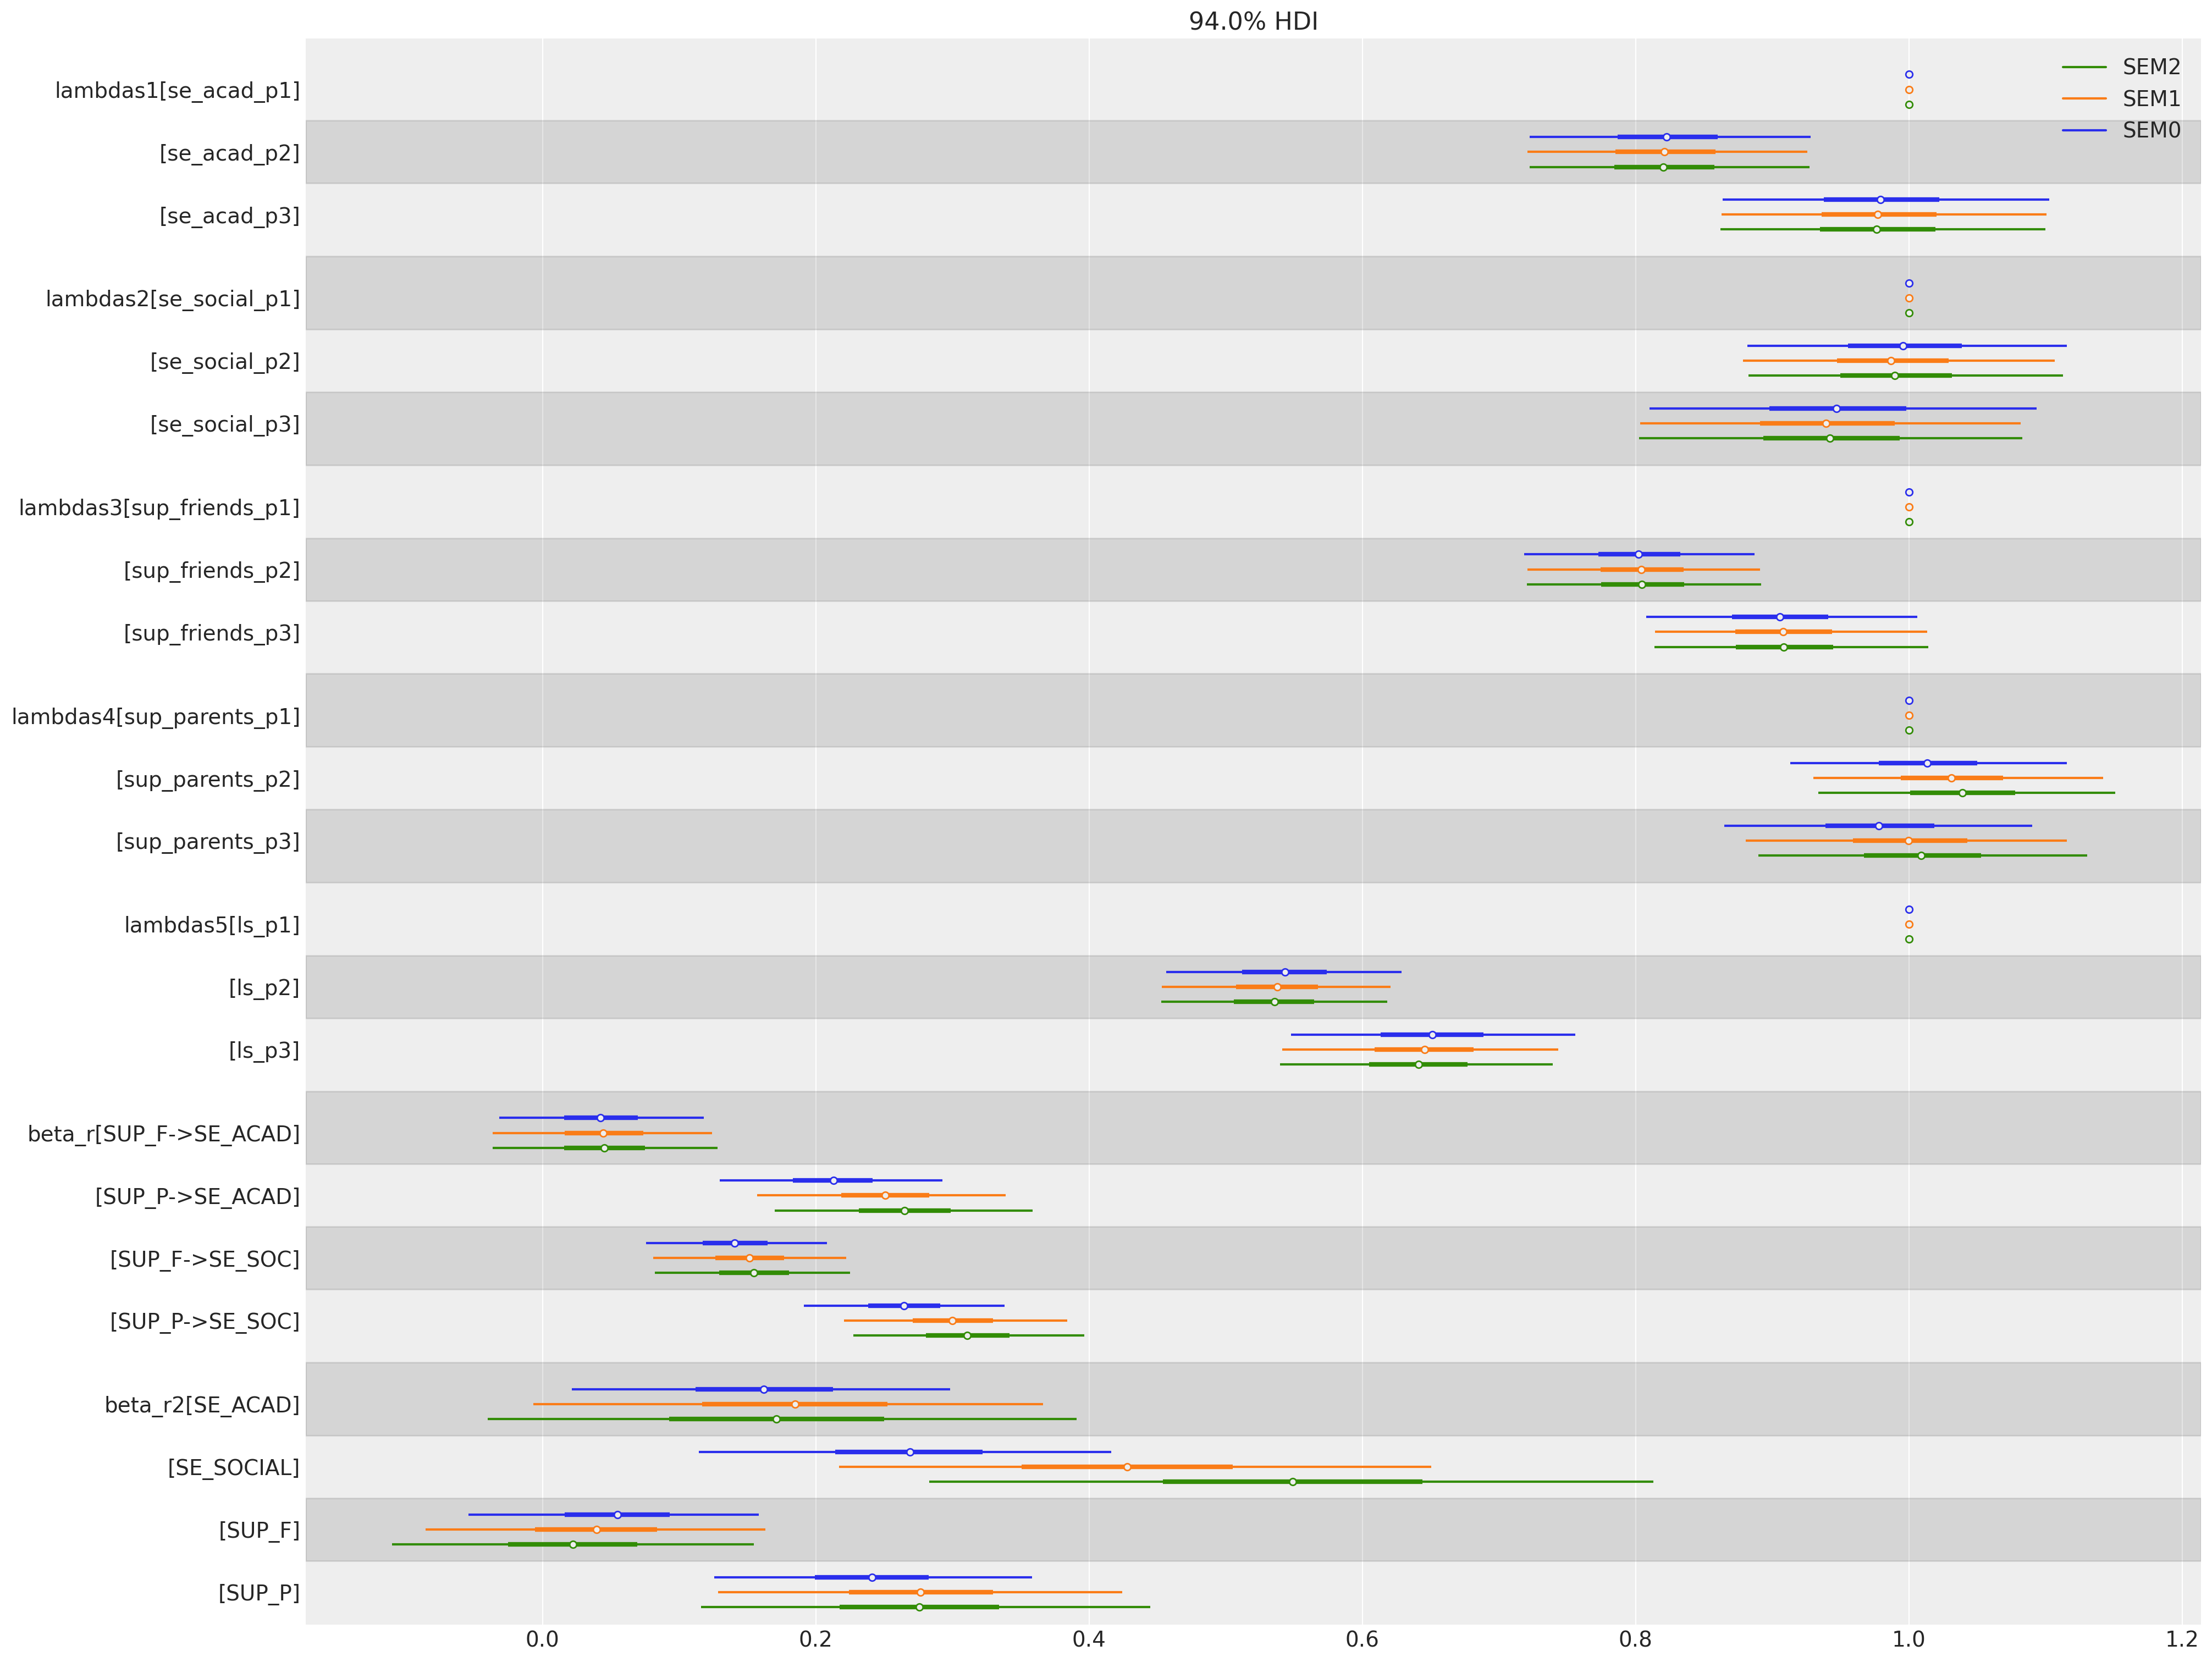

In [21]:
fig, ax = plt.subplots(figsize=(20, 15))
az.plot_forest(
    [idata_sem0, idata_sem1, idata_sem2],
    model_names=["SEM0", "SEM1", "SEM2"],
    var_names=["lambdas1", "lambdas2", "lambdas3", "lambdas4", "lambdas5", "beta_r", "beta_r2"],
    combined=True,
    ax=ax,
);

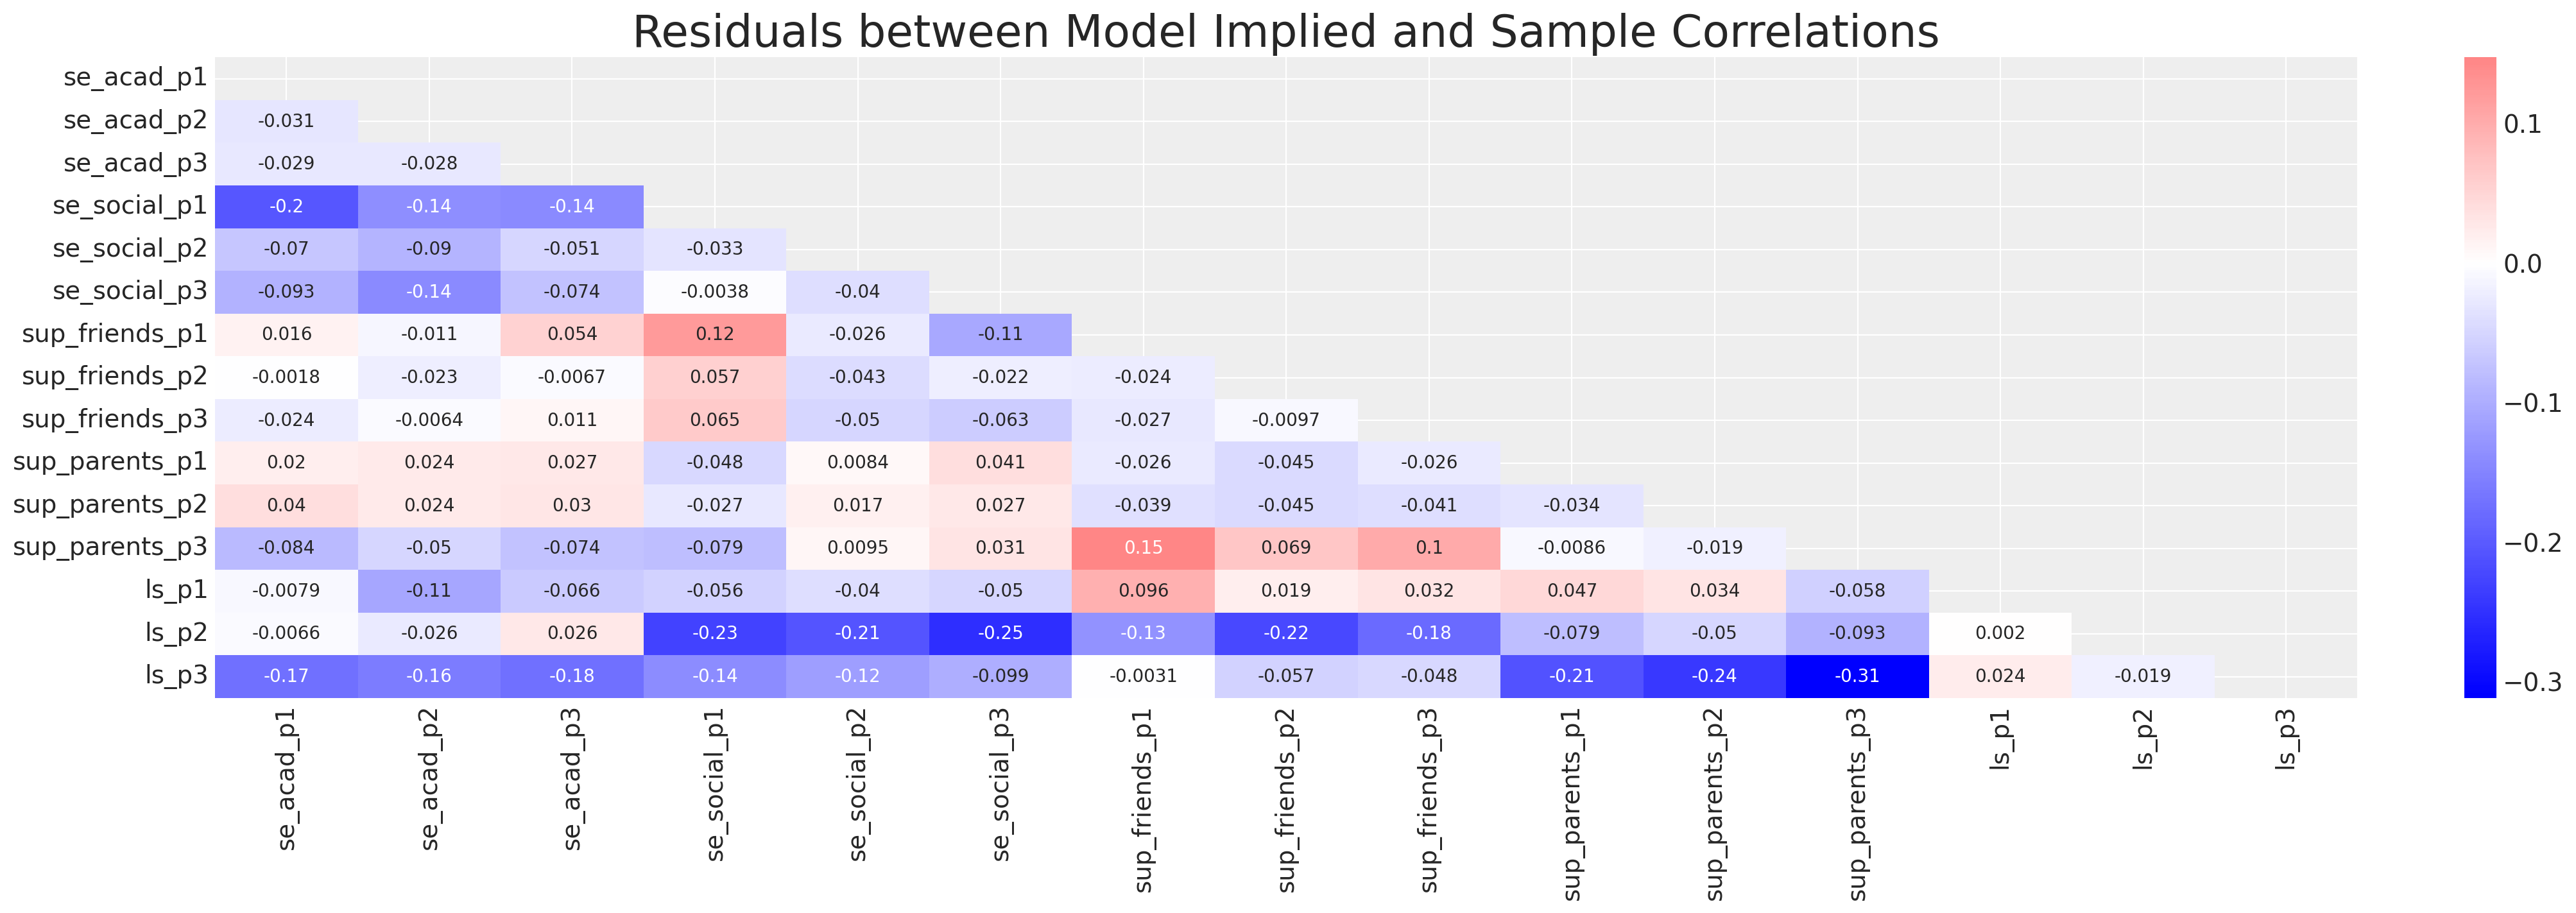

In [22]:
residuals_posterior_cov = get_posterior_resids(idata_sem0, 2500)
residuals_posterior_corr = get_posterior_resids(idata_sem0, 2500, metric="corr")

fig, ax = plt.subplots(figsize=(20, 7))
mask = np.triu(np.ones_like(residuals_posterior_corr, dtype=bool))
ax = sns.heatmap(residuals_posterior_corr, annot=True, cmap="bwr", center=0, mask=mask)
ax.set_title("Residuals between Model Implied and Sample Correlations", fontsize=25);

/var/folders/__/ng_3_9pn1f11ftyml_qr69vh0000gn/T/ipykernel_45611/3491944590.py:25: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


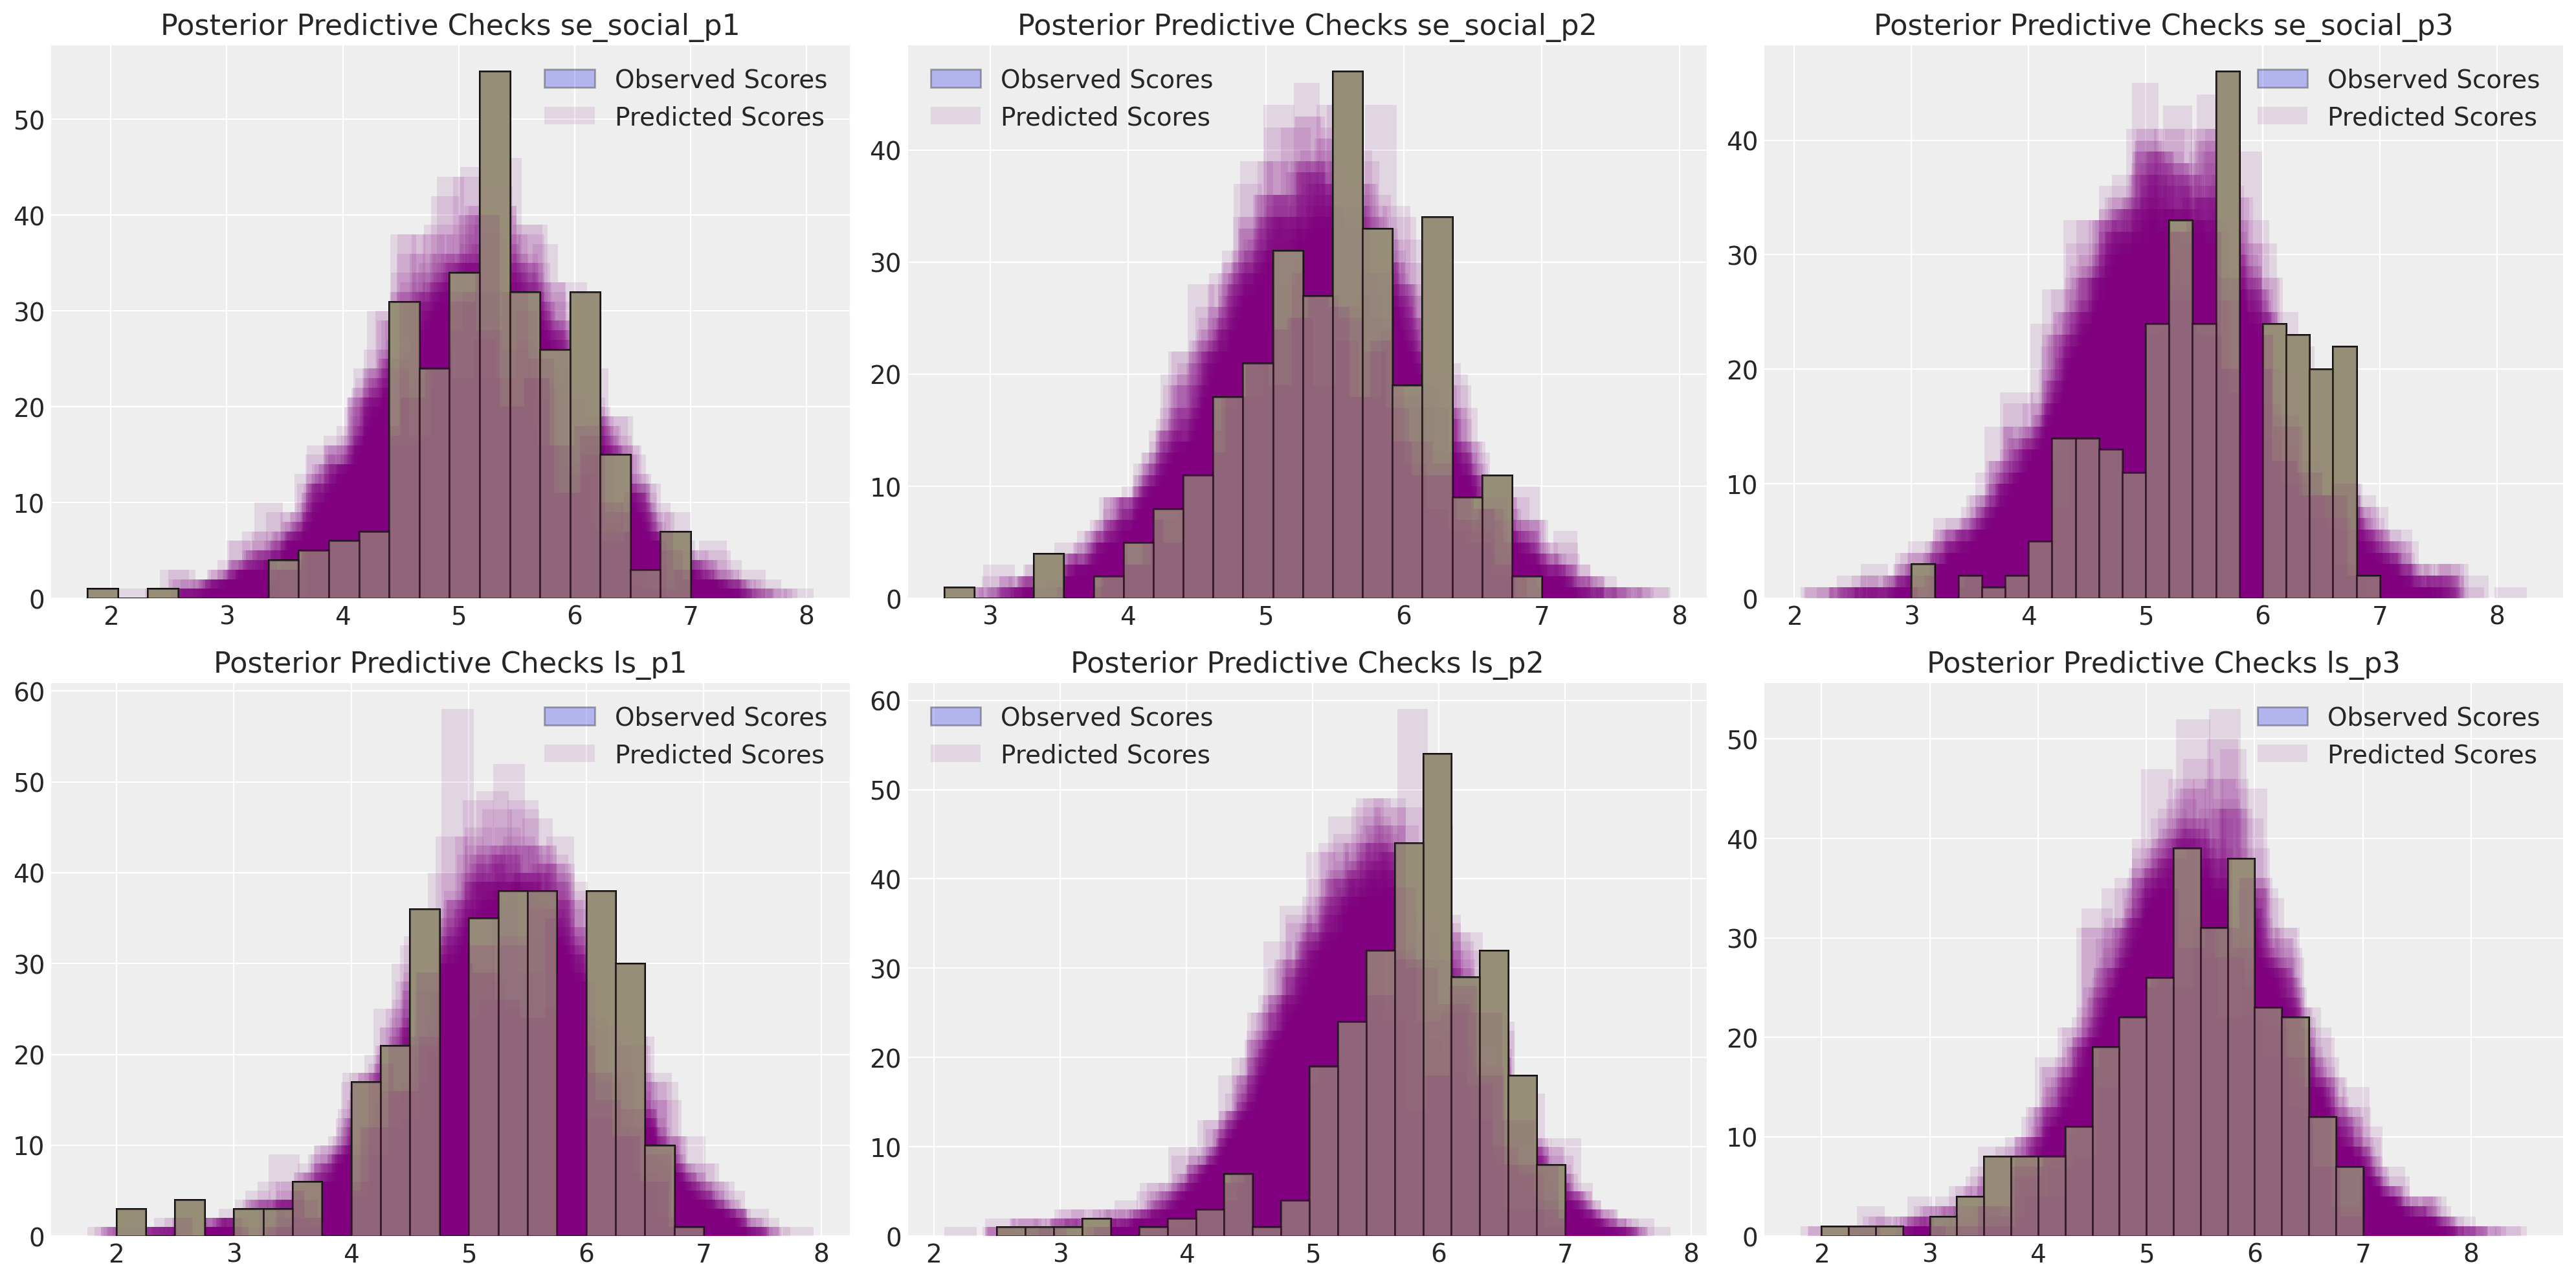

In [23]:
make_ppc(idata_sem0)

In [24]:
def calculate_effects(idata, var="SUP_P"):
    summary_df = az.summary(idata, var_names=["beta_r", "beta_r2"])
    # Indirect Paths
    ## VAR -> SE_SOC ->LS
    indirect_parent_soc = (
        summary_df.loc[f"beta_r[{var}->SE_SOC]"]["mean"]
        * summary_df.loc["beta_r2[SE_SOCIAL]"]["mean"]
    )

    ## VAR -> SE_SOC ->LS
    indirect_parent_acad = (
        summary_df.loc[f"beta_r[{var}->SE_ACAD]"]["mean"]
        * summary_df.loc["beta_r2[SE_ACAD]"]["mean"]
    )

    ## Total Indirect Effects
    total_indirect = indirect_parent_soc + indirect_parent_acad

    ## Total Effects
    total_effect = total_indirect + summary_df.loc[f"beta_r2[{var}]"]["mean"]

    return pd.DataFrame(
        [[indirect_parent_soc, indirect_parent_acad, total_indirect, total_effect]],
        columns=[
            f"{var} -> SE_SOC ->LS",
            f"{var} -> SE_ACAD ->LS",
            f"Total Indirect Effects {var}",
            f"Total Effects {var}",
        ],
    )

In [25]:
summary_p = pd.concat(
    [calculate_effects(idata_sem0), calculate_effects(idata_sem1), calculate_effects(idata_sem2)]
)

summary_p.index = ["SEM0", "SEM1", "SEM2"]
summary_p

SUP_P -> SE_SOC ->LS  SUP_P -> SE_ACAD ->LS  \
SEM0              0.071285               0.034719   
SEM1              0.128828               0.046435   
SEM2              0.171050               0.045580   

      Total Indirect Effects SUP_P  Total Effects SUP_P  
SEM0                      0.106004             0.347004  
SEM1                      0.175263             0.452263  
SEM2                      0.216630             0.492630

In [26]:
summary_f = pd.concat(
    [
        calculate_effects(idata_sem0, "SUP_F"),
        calculate_effects(idata_sem1, "SUP_F"),
        calculate_effects(idata_sem2, "SUP_F"),
    ]
)

summary_f.index = ["SEM0", "SEM1", "SEM2"]
summary_f

SUP_F -> SE_SOC ->LS  SUP_F -> SE_ACAD ->LS  \
SEM0              0.037929               0.007009   
SEM1              0.065056               0.008325   
SEM2              0.085250               0.007912   

      Total Indirect Effects SUP_F  Total Effects SUP_F  
SEM0                      0.044938             0.099938  
SEM1                      0.073381             0.112381  
SEM2                      0.093162             0.115162

## Authors
- Authored by [Nathaniel Forde](https://nathanielf.github.io/posts/post-with-code/CFA_AND_SEM/CFA_AND_SEM.html) in September 2024 

## References
:::{bibliography}
:filter: docname in docnames
:::

## Watermark

In [27]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor

Last updated: Mon Sep 02 2024

Python implementation: CPython
Python version       : 3.11.7
IPython version      : 8.20.0

pytensor: 2.18.6

matplotlib: 3.8.2
arviz     : 0.17.0
numpy     : 1.24.4
seaborn   : 0.13.2
pytensor  : 2.18.6
pandas    : 2.2.0
pymc      : 5.10.3

Watermark: 2.4.3

